In [2]:
import os
import random
from sklearn.model_selection import train_test_split
from data_reader import MaldiDataset
import numpy as np
from scipy.spatial.distance import euclidean
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib

In [3]:
# Set all seeds to make the results reproducible
random.seed(42)
np.random.seed(42)


# This script is a simple starting point to classify fungal data using MALDI-TOF spectra.
class SimpleFungusDataLoader:
    def __init__(self, dataset_path, test_size=0.2, random_state=42):
        # Initialize the classifier with dataset path, test size, and random state for reproducibility.
        self.dataset_path = dataset_path
        self.test_size = test_size
        self.random_state = random_state
        self.data = None
        self.train_data = []
        self.test_data = []

    def load_data(self, n_step):
        # Load the dataset using MaldiDataset
        dataset = MaldiDataset(self.dataset_path, n_step=n_step)
        dataset.parse_dataset()  # Parse the dataset from the specified path
        self.data = dataset.get_data()  # Retrieve the parsed data


    def split_data_stratify(self):
        """
        Divide los datos en train y test de forma estratificada según 'genus_species_label',
        asegurando que no haya solapamiento de 'unique_id_label' entre ambos conjuntos.
        Las clases con menos de 2 instancias se asignan directamente al conjunto de entrenamiento.
        """
        # Convertir los datos en un DataFrame
        df = pd.DataFrame(self.data)

        # Agrupar por 'unique_id_label' y seleccionar una clase representativa ('genus_species_label') para cada grupo
        unique_id_groups = df.groupby('unique_id_label').first().reset_index()

        # Identificar las clases con menos de 2 instancias
        class_counts = unique_id_groups['genus_species_label'].value_counts()
        small_classes = class_counts[class_counts < 2].index

        # Separar los grupos con clases pequeñas y el resto
        small_class_groups = unique_id_groups[unique_id_groups['genus_species_label'].isin(small_classes)]
        remaining_groups = unique_id_groups[~unique_id_groups['genus_species_label'].isin(small_classes)]

        # Estratificar las clases restantes
        train_ids, test_ids = train_test_split(
            remaining_groups['unique_id_label'],
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=remaining_groups['genus_species_label']  # Usar 'genus_species_label' como criterio de estratificación
        )

        # Agregar todas las instancias de clases pequeñas al conjunto de entrenamiento
        train_ids = pd.concat([pd.Series(train_ids), small_class_groups['unique_id_label']])

        # Filtrar el DataFrame original para crear los conjuntos de train y test
        self.train_data = df[df['unique_id_label'].isin(train_ids)]  # DataFrame de entrenamiento
        self.test_data = df[df['unique_id_label'].isin(test_ids)]  # DataFrame de prueba

        # Verificar que no haya solapamiento de 'unique_id_label' entre train y test
        train_unique_ids = set(self.train_data['unique_id_label'])
        test_unique_ids = set(self.test_data['unique_id_label'])
        assert len(train_unique_ids.intersection(test_unique_ids)) == 0, "Unique ID labels overlap between train and test"

        # Imprimir estadísticas
        print(f"Number of unique_id_labels in train data: {len(train_unique_ids)}")
        print(f"Number of unique_id_labels in test data: {len(test_unique_ids)}")
        print(f"Number of samples in train data: {len(self.train_data)}")
        print(f"Number of samples in test data: {len(self.test_data)}")
        print(f"Number of classes to predict: {len(self.train_data['genus_species_label'].unique())}")



    def plot_data_distribution(self):
        """
        Grafica la distribución de las clases ('genus_species_label') en los conjuntos de
        entrenamiento y prueba para visualizar las proporciones después de la división estratificada.
        """
        # Contar las etiquetas en los conjuntos de entrenamiento y prueba
        train_counts = self.train_data['genus_species_label'].value_counts()
        test_counts = self.test_data['genus_species_label'].value_counts()

        # Unificar las etiquetas para asegurar que ambas series tengan los mismos índices
        all_labels = pd.Index(train_counts.index).union(test_counts.index)
        train_counts = train_counts.reindex(all_labels, fill_value=0)
        test_counts = test_counts.reindex(all_labels, fill_value=0)

        # Crear gráfico
        x = np.arange(len(all_labels))  # Posiciones de las barras
        width = 0.4  # Ancho de las barras

        plt.figure(figsize=(14, 8))  # Tamaño del gráfico
        plt.bar(x - width / 2, train_counts, width, label='Train', alpha=0.8, color='blue')
        plt.bar(x + width / 2, test_counts, width, label='Test', alpha=0.8, color='orange')

        # Configurar etiquetas y título
        plt.xlabel('Genus+Species Label', fontsize=12)
        plt.ylabel('Number of Samples', fontsize=12)
        plt.title('Distribution of Genus+Species Labels in Train and Test Data', fontsize=14)
        plt.xticks(x, all_labels, rotation=90, fontsize=10)  # Etiquetas en el eje X
        plt.legend(fontsize=12)

        # Ajustar diseño
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    def get_train_data(self):
        return self.train_data
    
    def get_test_data(self):
        return self.test_data
    

        


In [4]:
# Define the dataset path (update this path to where your dataset is located)
dataset_path = "data/fungus_db"

# Initialize the classifier with the dataset path
fungus_identifier = SimpleFungusDataLoader(dataset_path)

fungus_identifier.load_data(n_step=6)

# Load and split the data into training and test sets.
fungus_identifier.split_data_stratify()

c:\Users\aleta\Documents\TFM\FungusClassifier\data_reader.py:299: RuntimeWarning: invalid value encountered in divide
  intensity=SpectrumObj.intensity / SpectrumObj.intensity.sum() * self.sum,


Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Number of unique_id_labels in train data: 268
Number of unique_id_labels in test data: 64
Number of samples in train data: 6452
Number of samples in test data: 1476
Number of classes to predict: 60


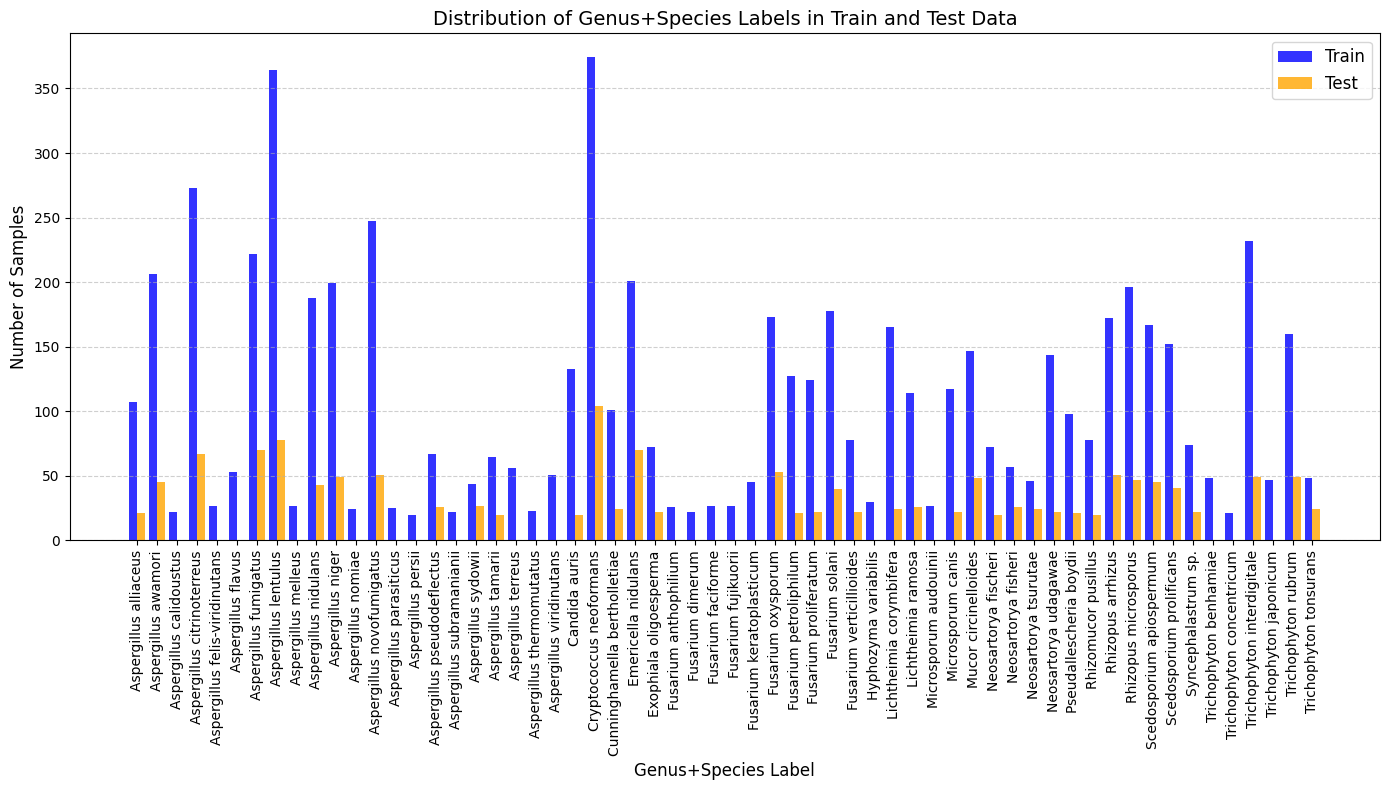

In [5]:
fungus_identifier.plot_data_distribution()

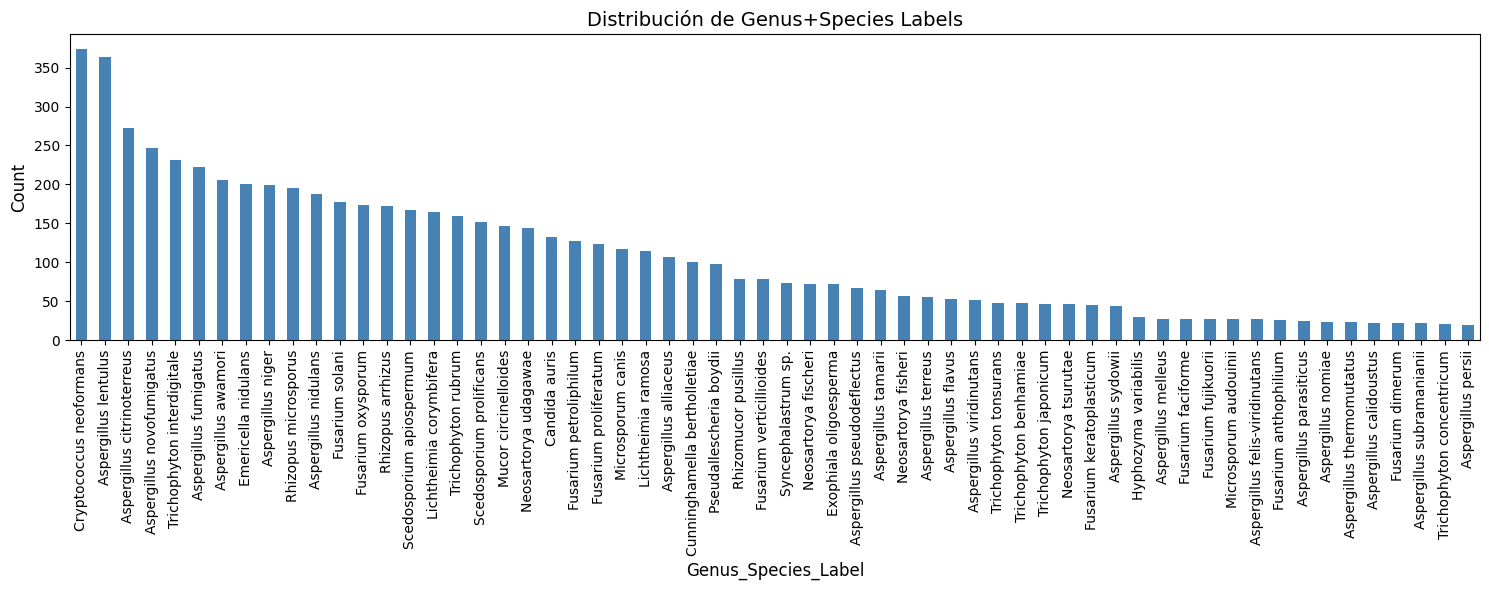

In [6]:
# Crear el gráfico de barras
plt.figure(figsize=(15, 6))  # Ajustar el tamaño del gráfico
fungus_identifier.train_data['genus_species_label'].value_counts().plot(kind='bar', color='steelblue')

# Rotar las etiquetas del eje X para que no se solapen
plt.xticks(rotation=90, fontsize=10)  # Rotar 90 grados y ajustar el tamaño de fuente

# Agregar etiquetas y título
plt.xlabel('Genus_Species_Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribución de Genus+Species Labels', fontsize=14)

# Ajustar el diseño para evitar solapamiento
plt.tight_layout()

# Mostrar el gráfico
plt.show()


<Axes: xlabel='genus_label'>

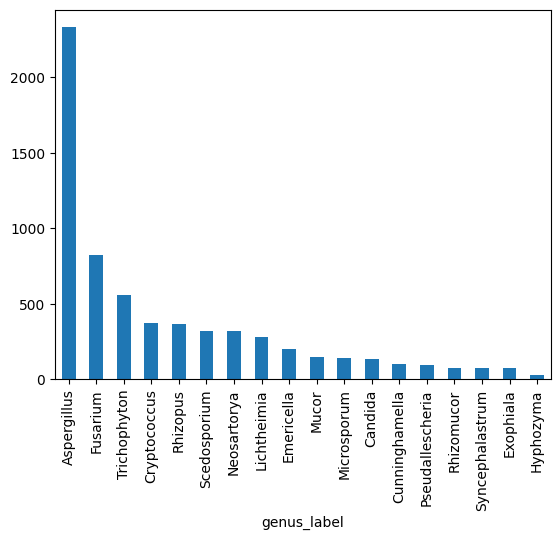

In [7]:
fungus_identifier.train_data['genus_label'].value_counts().plot(kind='bar')

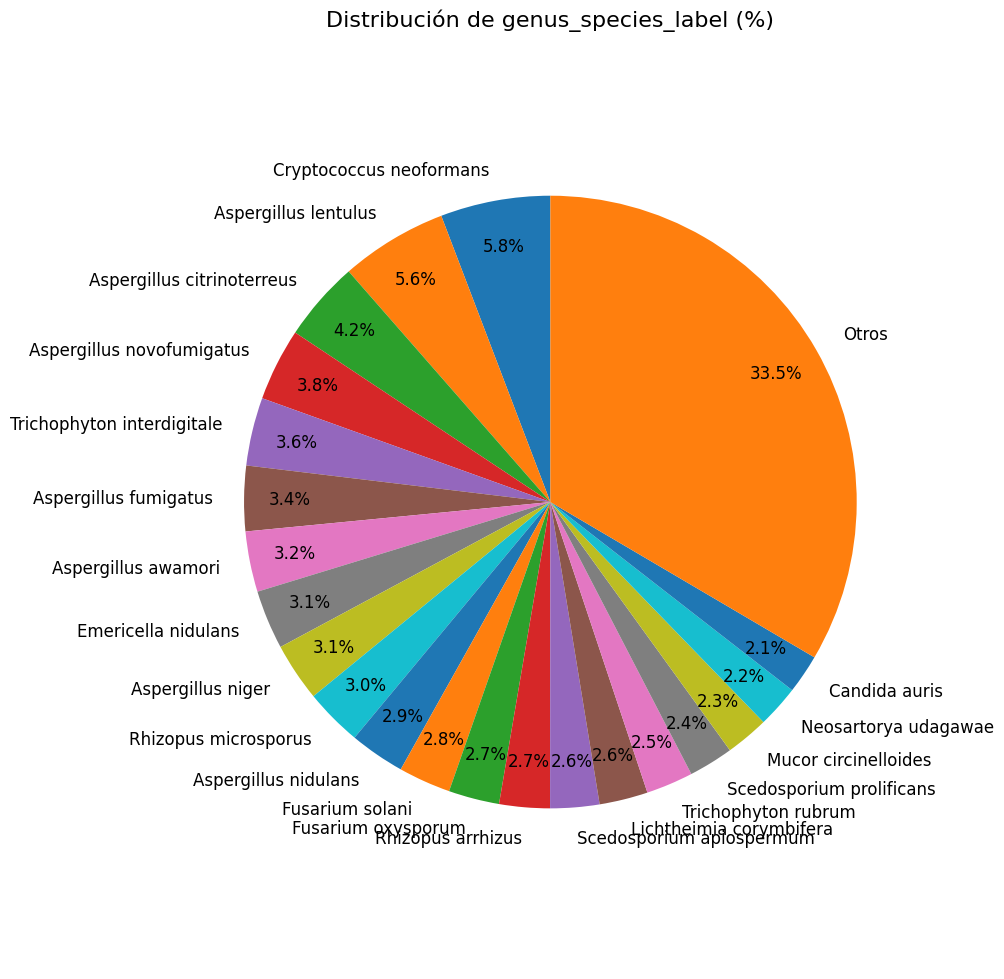

In [8]:
# Calcular los conteos y porcentajes
value_counts = fungus_identifier.train_data['genus_species_label'].value_counts()
percentages = value_counts / value_counts.sum() * 100

# Agrupar categorías pequeñas
threshold = 2  # Porcentaje mínimo para mostrar individualmente
large_categories = percentages[percentages >= threshold]
small_categories = percentages[percentages < threshold].sum()
percentages_filtered = pd.concat([large_categories, pd.Series({'Otros': small_categories})])

# Crear el gráfico circular con líneas de conexión
plt.figure(figsize=(10, 10))  # Aumentar el tamaño del gráfico
plt.pie(
    percentages_filtered,
    labels=percentages_filtered.index,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 12},
    pctdistance=0.85,  # Porcentajes más cerca del centro
    labeldistance=1.1  # Etiquetas más alejadas del centro
)
plt.title('Distribución de genus_species_label (%)', fontsize=16)
plt.axis('equal')  # Asegurar que el gráfico sea circular
plt.tight_layout()  # Ajustar elementos automáticamente
plt.show()

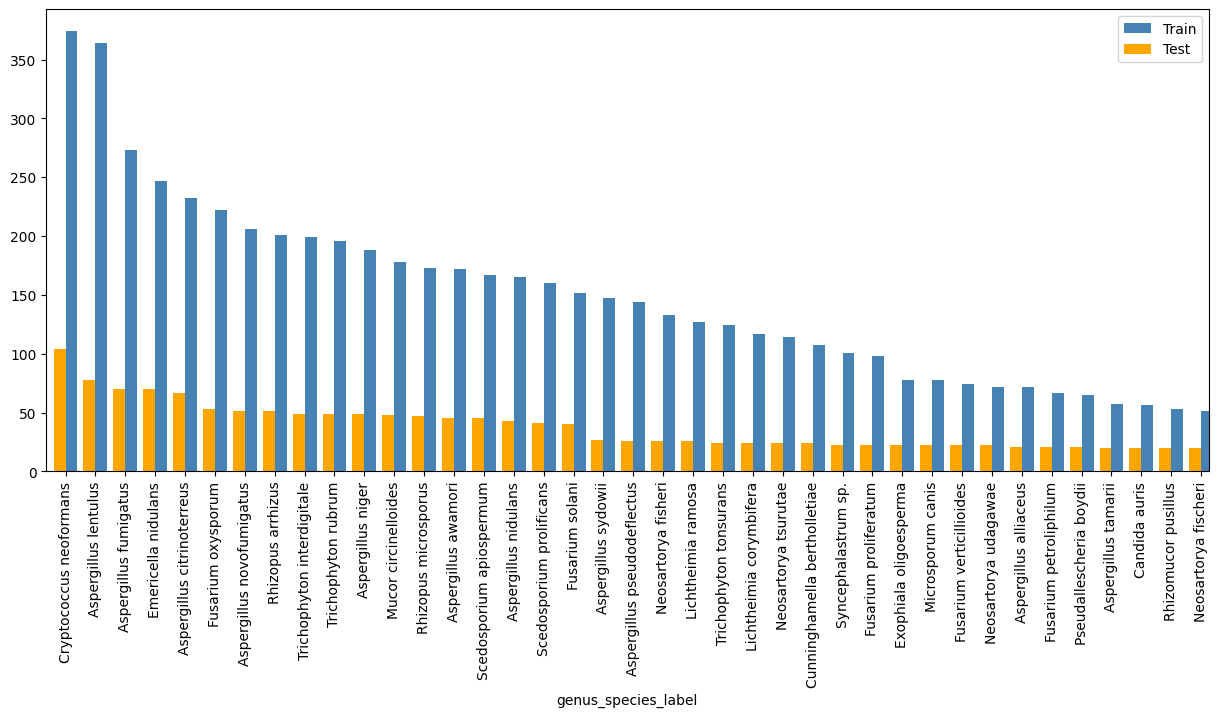

In [9]:
#Comparar la distribución de las etiquetas en los conjuntos de entrenamiento y prueba
plt.figure(figsize=(15, 6))  # Ajustar el tamaño del gráfico
fungus_identifier.train_data['genus_species_label'].value_counts().plot(kind='bar', color='steelblue', position=0, width=0.4, label='Train')
fungus_identifier.test_data['genus_species_label'].value_counts().plot(kind='bar', color='orange', position=1, width=0.4, label='Test')
plt.legend()

In [10]:
train_data = fungus_identifier.get_train_data()
test_data = fungus_identifier.get_test_data()

In [11]:
label_encoder_genus = LabelEncoder()
label_encoder_genus_species = LabelEncoder()
train_data['genus_species_label'] = label_encoder_genus_species.fit_transform(train_data['genus_species_label'])
train_data['genus_label'] = label_encoder_genus.fit_transform(train_data['genus_label'])
test_data['genus_species_label'] = label_encoder_genus_species.transform(test_data['genus_species_label'])
test_data['genus_label'] = label_encoder_genus.transform(test_data['genus_label'])

spectra_normalized = []
for spectrum in train_data['spectrum']:
    scaler = StandardScaler()
    # Asegurar que el spectrum sea un array 2D
    spectrum_2d = np.array(spectrum).reshape(-1, 1)
    spectrum_normalized = scaler.fit_transform(spectrum_2d).flatten()  # Reducir a 1D nuevamente
    spectra_normalized.append(spectrum_normalized)
train_data['spectrum'] = spectra_normalized

spectra_normalized = []
for spectrum in test_data['spectrum']:
    scaler = StandardScaler()
    # Asegurar que el spectrum sea un array 2D
    spectrum_2d = np.array(spectrum).reshape(-1, 1)
    spectrum_normalized = scaler.fit_transform(spectrum_2d).flatten()  # Reducir a 1D nuevamente
    spectra_normalized.append(spectrum_normalized)
test_data['spectrum'] = spectra_normalized

In [12]:
x_train = train_data.drop(columns=['genus_species_label', 'genus_label', 'unique_id_label','m/z'])
genus_label_train = train_data['genus_label']
genus_species_label_train = train_data['genus_species_label']
x_test = test_data.drop(columns=['genus_species_label', 'genus_label', 'unique_id_label','m/z'])
genus_label_test = test_data['genus_label']
genus_species_label_test = test_data['genus_species_label']


In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def evaluate_knn_classifier(x_test, y_test, knn_classifier, classes=None, figsize=(20, 20), fontsize=8, zero_division=0):
    """
    Evalúa un clasificador KNN en datos de prueba e incluye métricas detalladas,
    además de graficar la matriz de confusión sin la barra de color (colorbar).
    """
    # Predicciones del clasificador
    y_pred = knn_classifier.predict(x_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    print(f"KNN Classifier Accuracy: {accuracy:.2f}")
    
    print("\nClassification Report:")
    print(
        classification_report(
            y_test, 
            y_pred, 
            target_names=classes, 
            zero_division=zero_division  # Evitar el warning
        )
    )
    
    # Generar la matriz de confusión (solo con las clases presentes en y_test e y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print("\nConfusion Matrix:")
    print(cm)
    
    # Obtener etiquetas reales del clasificador (todas las clases vistas en el entrenamiento)
    real_class_labels = knn_classifier.classes_
    
    # Identificar las clases presentes en el conjunto de prueba/predicciones
    unique_classes_in_test = np.unique(np.concatenate((y_test, y_pred)))
    
    # Filtrar etiquetas reales para mostrar solo las clases presentes en la matriz de confusión
    display_labels = [str(label) for label in real_class_labels if label in unique_classes_in_test]
    
    # Graficar la matriz de confusión sin la barra de color
    fig, ax = plt.subplots(figsize=figsize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap="Blues", ax=ax, colorbar=False)  # Aquí desactivamos la barra de color
    
    # Ajustar etiquetas y título
    plt.xticks(fontsize=fontsize, rotation=90)
    plt.yticks(fontsize=fontsize)
    plt.title("Confusion Matrix", fontsize=fontsize + 4)
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'predicted_labels': y_pred,
        'true_labels': y_test
    }


# BASELINE: KNN

## KNN con n_neighbors aleatorio

In [14]:
spectrum = np.array(train_data['spectrum'].tolist())
knn_genus_level = KNeighborsClassifier(n_neighbors=5)
knn_genus_level.fit(spectrum, genus_label_train)
knn_genus_species_level = KNeighborsClassifier(n_neighbors=5)
knn_genus_species_level.fit(spectrum, genus_species_label_train)

KNeighborsClassifier()

---------------------------- EVALUACIÓN A NIVEL DE GÉNERO -----------------------------------
KNN Classifier Accuracy: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       497
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00       104
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        70
           5       1.00      1.00      1.00        22
           6       1.00      1.00      1.00       158
           8       1.00      1.00      1.00        50
           9       1.00      1.00      1.00        22
          10       1.00      1.00      1.00        48
          11       1.00      0.50      0.67        92
          12       1.00      1.00      1.00        21
          13       0.00      0.00      0.00        20
          14       0.83      1.00      0.91        98
          15       1.00      1.00      1.

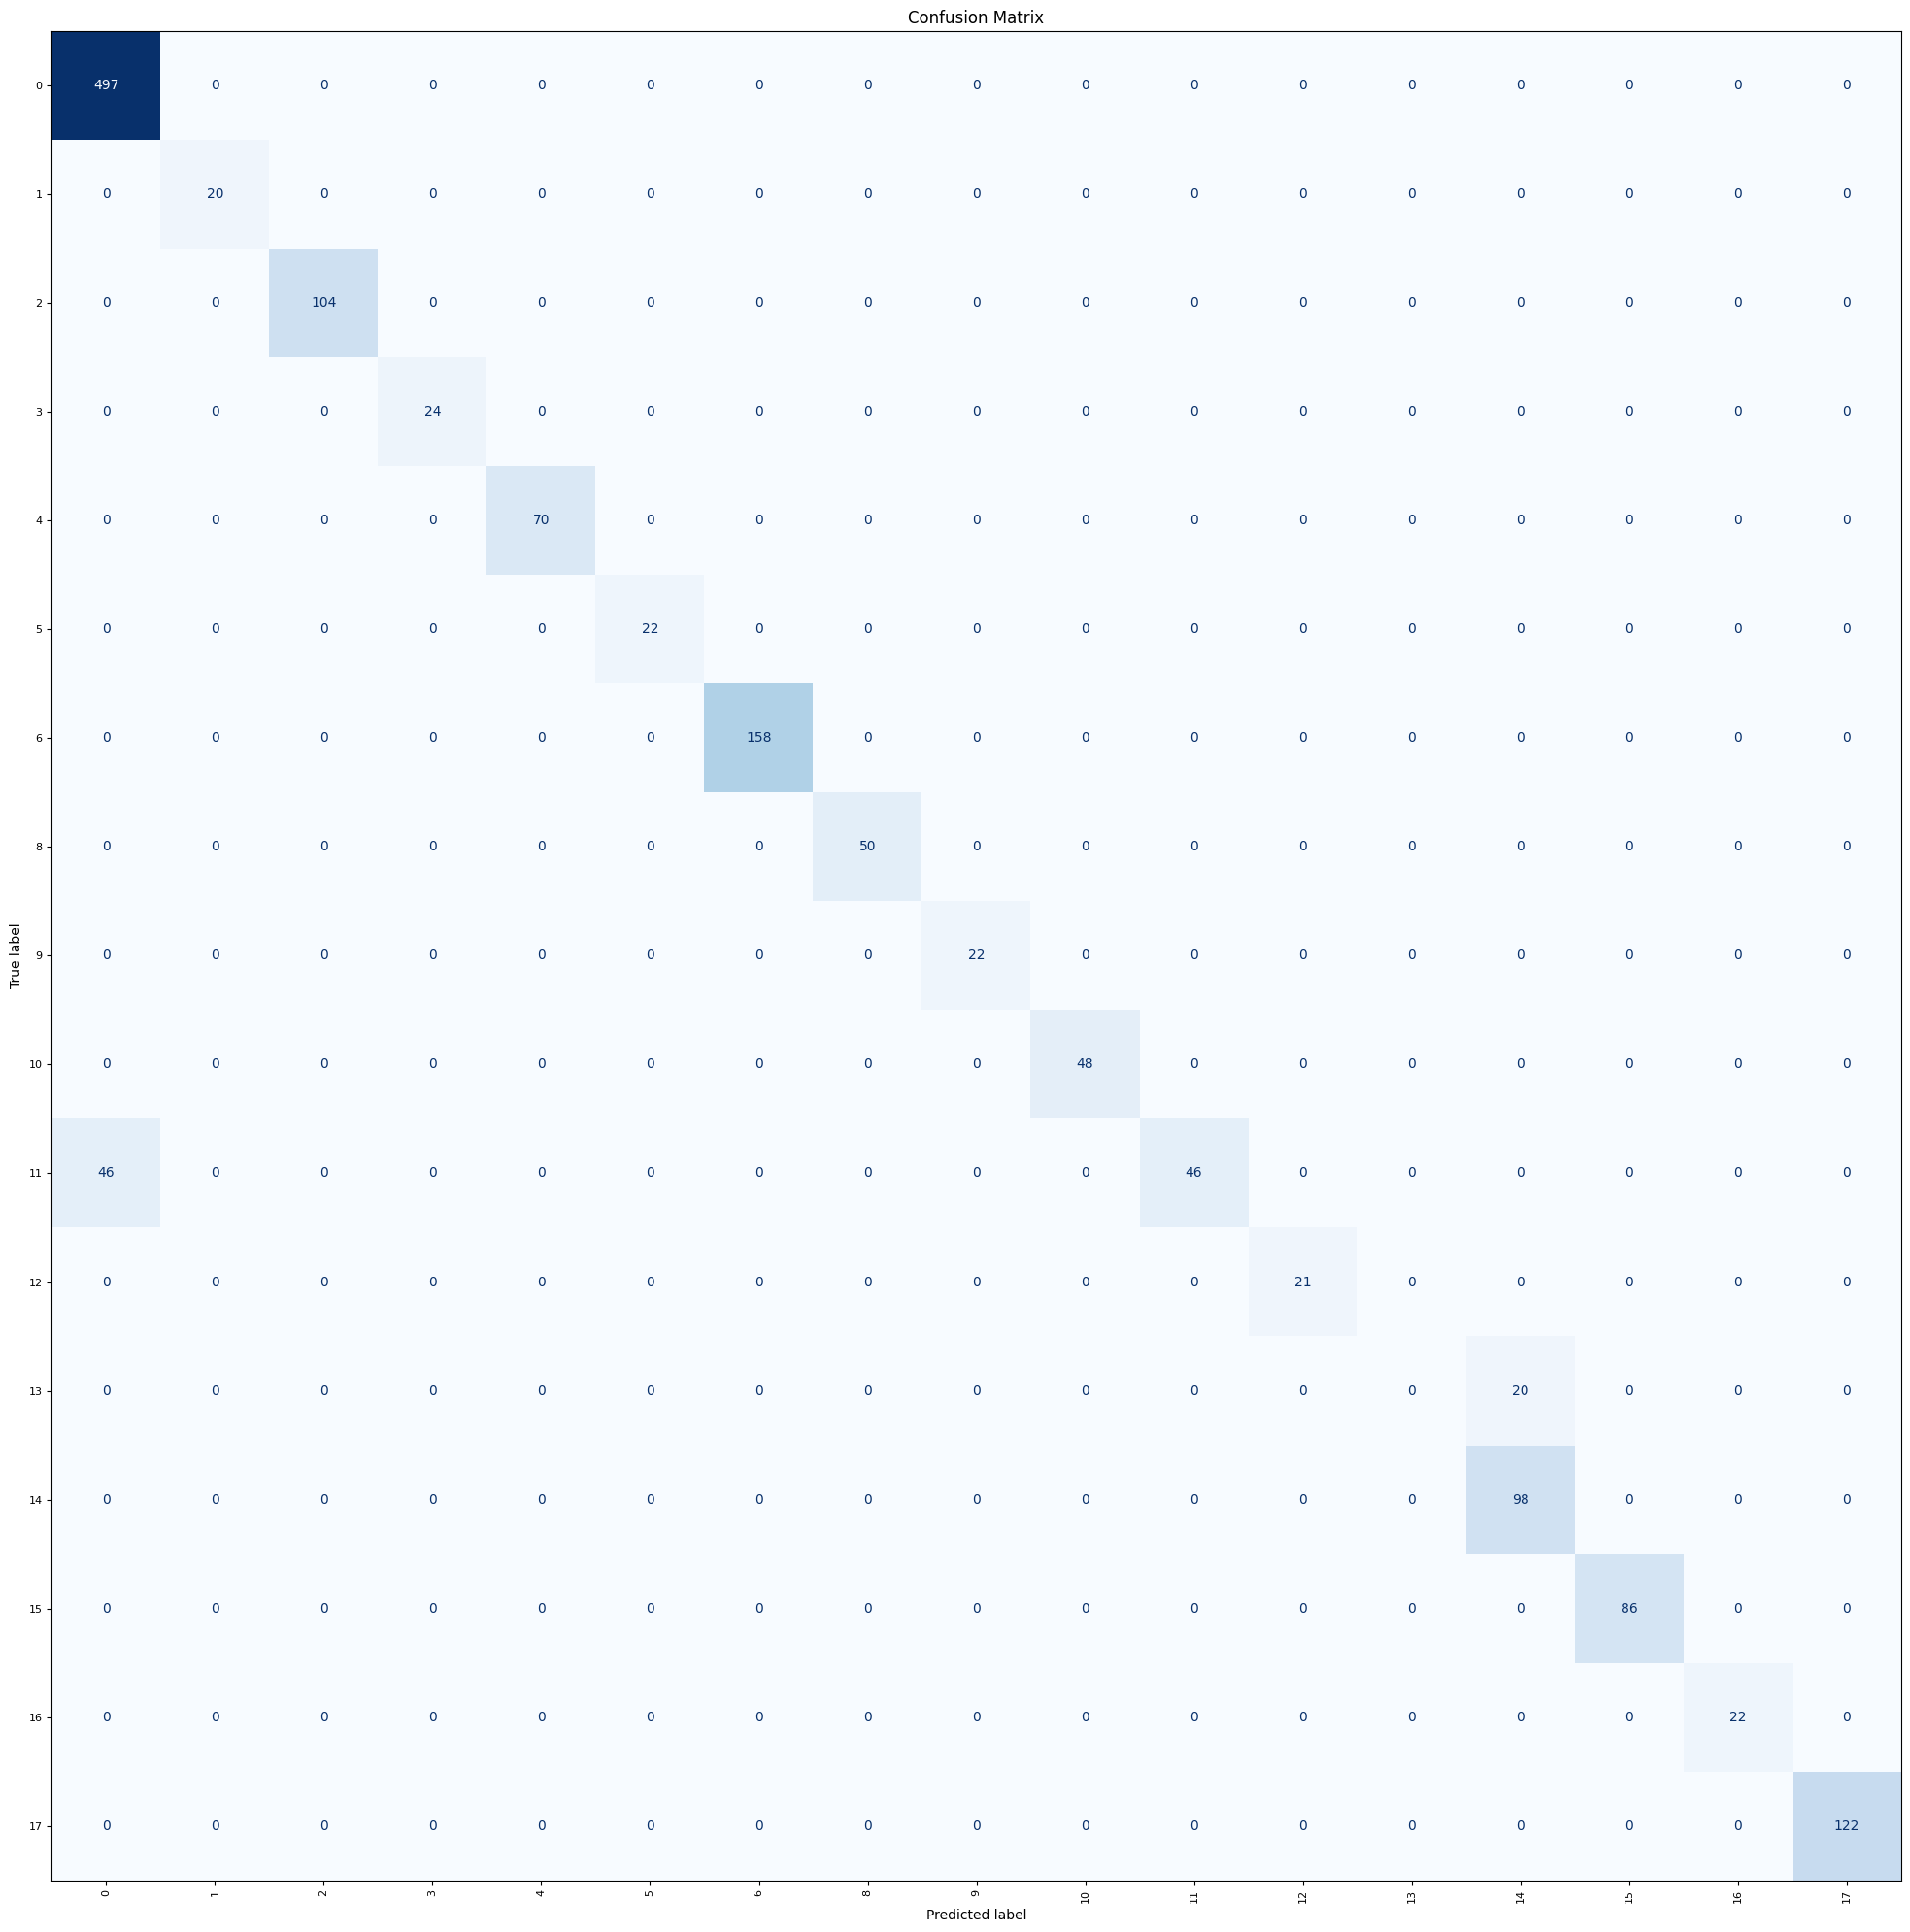

---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE -----------------------------------
KNN Classifier Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      0.31      0.47        45
           3       1.00      1.00      1.00        67
           6       1.00      1.00      1.00        70
           7       1.00      1.00      1.00        78
           9       1.00      1.00      1.00        43
          10       0.61      1.00      0.76        49
          12       1.00      1.00      1.00        51
          15       1.00      1.00      1.00        26
          17       1.00      1.00      1.00        27
          18       1.00      1.00      1.00        20
          20       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          22       1.00      1.00      1.00        20
          23       1.00      1.

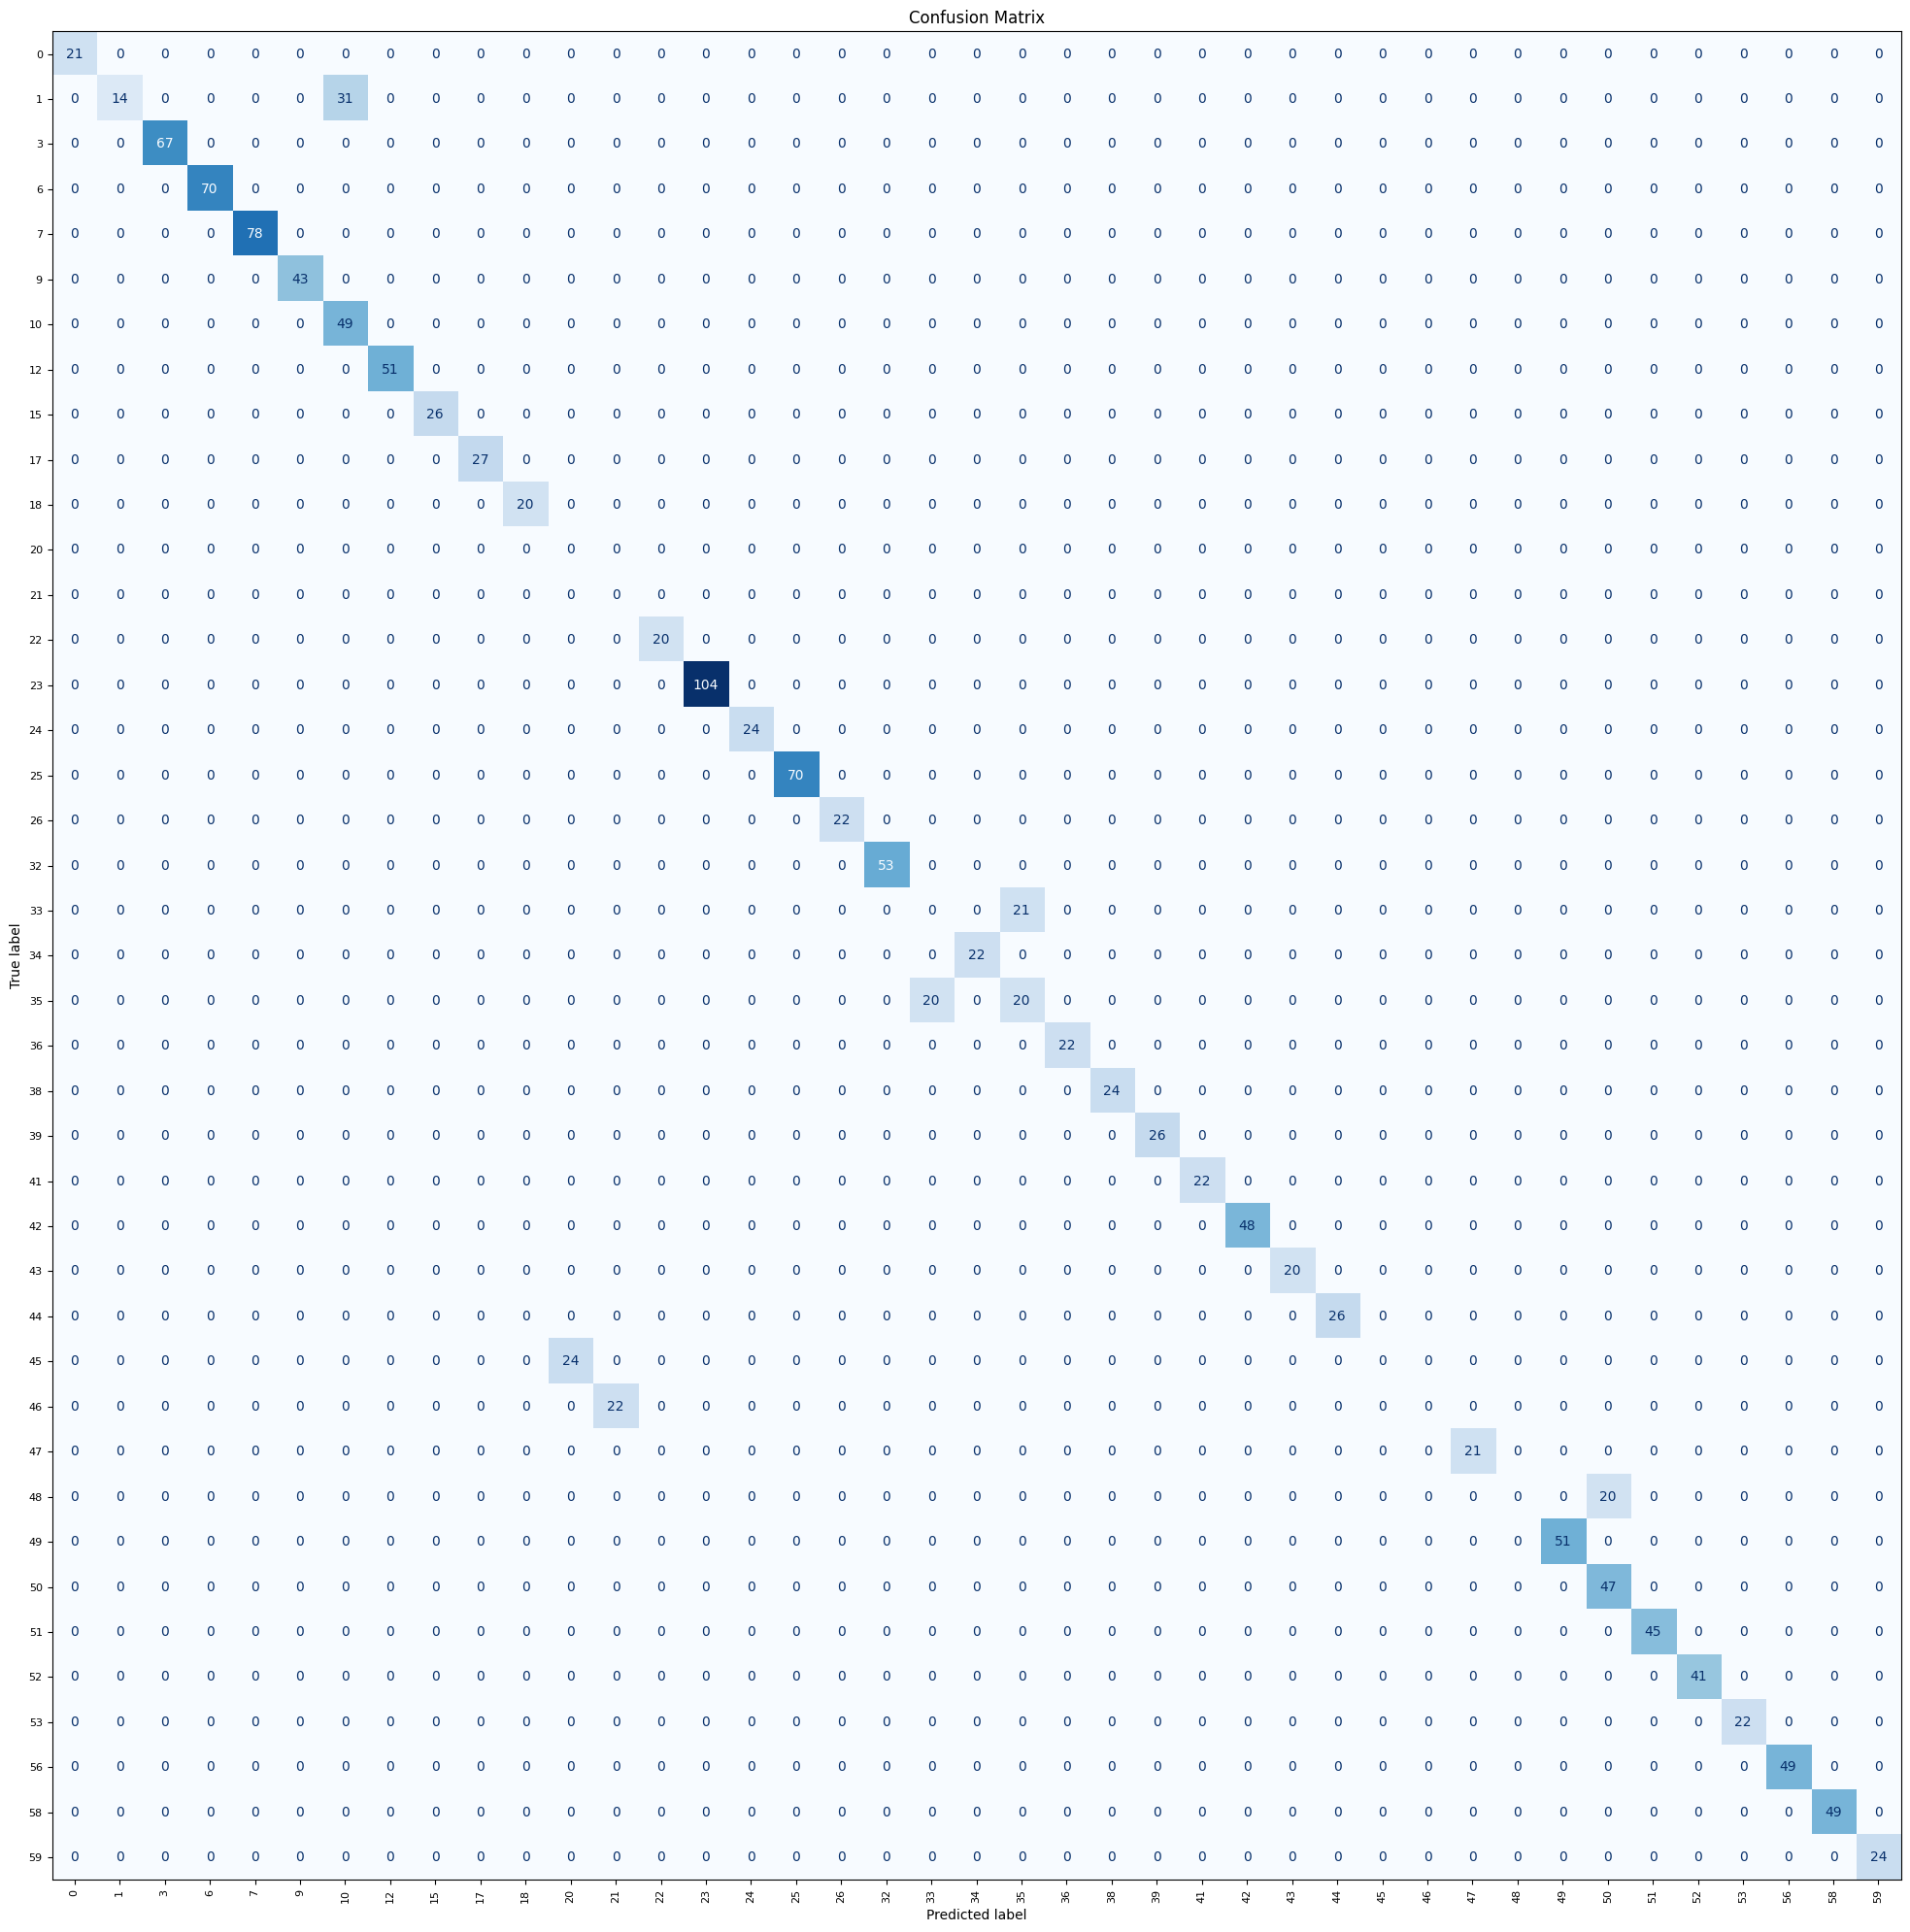

{'accuracy': 0.9065040650406504,
 'predicted_labels': array([ 0,  0,  0, ..., 59, 59, 59]),
 'true_labels': 86       0
 87       0
 88       0
 89       0
 90       0
         ..
 7875    59
 7876    59
 7877    59
 7878    59
 7879    59
 Name: genus_species_label, Length: 1476, dtype: int64}

In [15]:
spectrum_test = np.array(test_data['spectrum'].tolist())
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO -----------------------------------")
evaluate_knn_classifier(spectrum_test, genus_label_test, knn_genus_level)
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE -----------------------------------")
evaluate_knn_classifier(spectrum_test, genus_species_label_test, knn_genus_species_level)

In [39]:
#Concatena spectrum y spectrum_test
spectrum_completo = np.concatenate((spectrum, spectrum_test), axis=0)
genus_label_completo = np.concatenate((genus_label_train, genus_label_test), axis=0)
genus_label_completo

array([ 0,  0,  0, ..., 17, 17, 17])

## Aplicando grid search en busca de los mejores híper parámetros

In [13]:
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto','ball_tree', 'brute']
}

In [3]:
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=4,  # Validación cruzada
    scoring='accuracy',  # Métrica principal
    verbose=3,  # Mostrar progreso
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ajustar el modelo con los datos ya normalizados
grid_search.fit(spectrum, genus_species_label_train)

# Resultados del mejor modelo
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Score:", grid_search.best_score_)

NameError: name 'GridSearchCV' is not defined

In [124]:
joblib.dump(grid_search, "grid_search_knn.pkl")

['grid_search_knn.pkl']

In [128]:
knn_best = grid_search.best_estimator_
knn_best.fit(spectrum, genus_species_label_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [16]:
#cuenta el numero de Aspergillus fumigatus en el conjunto de test
id = label_encoder_genus_species.transform(['Aspergillus fumigatus'])[0]
count = Counter(genus_species_label_test)
print(f"Number of Aspergillus fumigatus in test set: {count[id]}")

Number of Aspergillus fumigatus in test set: 70


In [17]:
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE -----------------------------------")
evaluate_knn_classifier(spectrum_test, genus_species_label_test, knn_best)

---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE -----------------------------------


NameError: name 'knn_best' is not defined

In [ ]:
knn_best = grid_search.best_estimator_
knn_best.fit(spectrum, genus_label_train)

NameError: name 'grid_search' is not defined

In [ ]:
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO -----------------------------------")
evaluate_knn_classifier(spectrum_test, genus_label_test, knn_best)

---------------------------- EVALUACIÓN A NIVEL DE GÉNERO -----------------------------------


NameError: name 'knn_best' is not defined

## Usando SMOTE

In [18]:
train_data_for_SMOTE = train_data.copy().drop(columns=['genus_species_label', 'genus_label', 'unique_id_label','m/z'])
test_data_for_SMOTE = test_data.copy().drop(columns=['genus_species_label', 'genus_label', 'unique_id_label','m/z'])

In [19]:
spectrum_train_for_SMOTE = np.array(train_data_for_SMOTE['spectrum'].tolist())
smote = SMOTE(random_state=42)
x_train_smote, genus_species_smote = smote.fit_resample(spectrum_train_for_SMOTE, genus_species_label_train)

In [20]:
genus_species_smote_labels = label_encoder_genus_species.inverse_transform(genus_species_smote)
genus_smote_labels = [label.split()[0] for label in genus_species_smote_labels]
genus_smote = label_encoder_genus.transform(genus_smote_labels)

In [21]:
print(label_encoder_genus_species.transform(['Aspergillus fumigatus']))

[6]


In [22]:
#print correlations betwenn genus and his labels
print(label_encoder_genus.inverse_transform([6]))

['Fusarium']


In [23]:
knn_genus_species_level_smote = KNeighborsClassifier(n_neighbors=5)
knn_genus_species_level_smote.fit(x_train_smote, genus_species_smote)

KNeighborsClassifier()

In [24]:
import pandas as pd

pd.DataFrame(x_train_smote).to_csv('x_train_smote.csv', index=False)
pd.DataFrame(spectrum_test).to_csv('x_test_smote.csv', index=False)
pd.DataFrame(genus_species_smote).to_csv('genus_species_train_labels_smote.csv', index=False)
pd.DataFrame(genus_species_label_test).to_csv('genus_species_test_labels_smote.csv', index=False)
pd.DataFrame(genus_label_train).to_csv('genus_train_labels_smote.csv', index=False)
pd.DataFrame(genus_label_test).to_csv('genus_test_labels_smote.csv', index=False)


---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE CON SMOTE -----------------------------------
KNN Classifier Accuracy: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      0.24      0.39        45
           3       1.00      1.00      1.00        67
           6       1.00      1.00      1.00        70
           7       1.00      1.00      1.00        78
           9       1.00      1.00      1.00        43
          10       0.59      1.00      0.74        49
          12       1.00      1.00      1.00        51
          15       1.00      1.00      1.00        26
          17       1.00      1.00      1.00        27
          18       1.00      1.00      1.00        20
          20       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          22       1.00      1.00      1.00        20
          23       1.

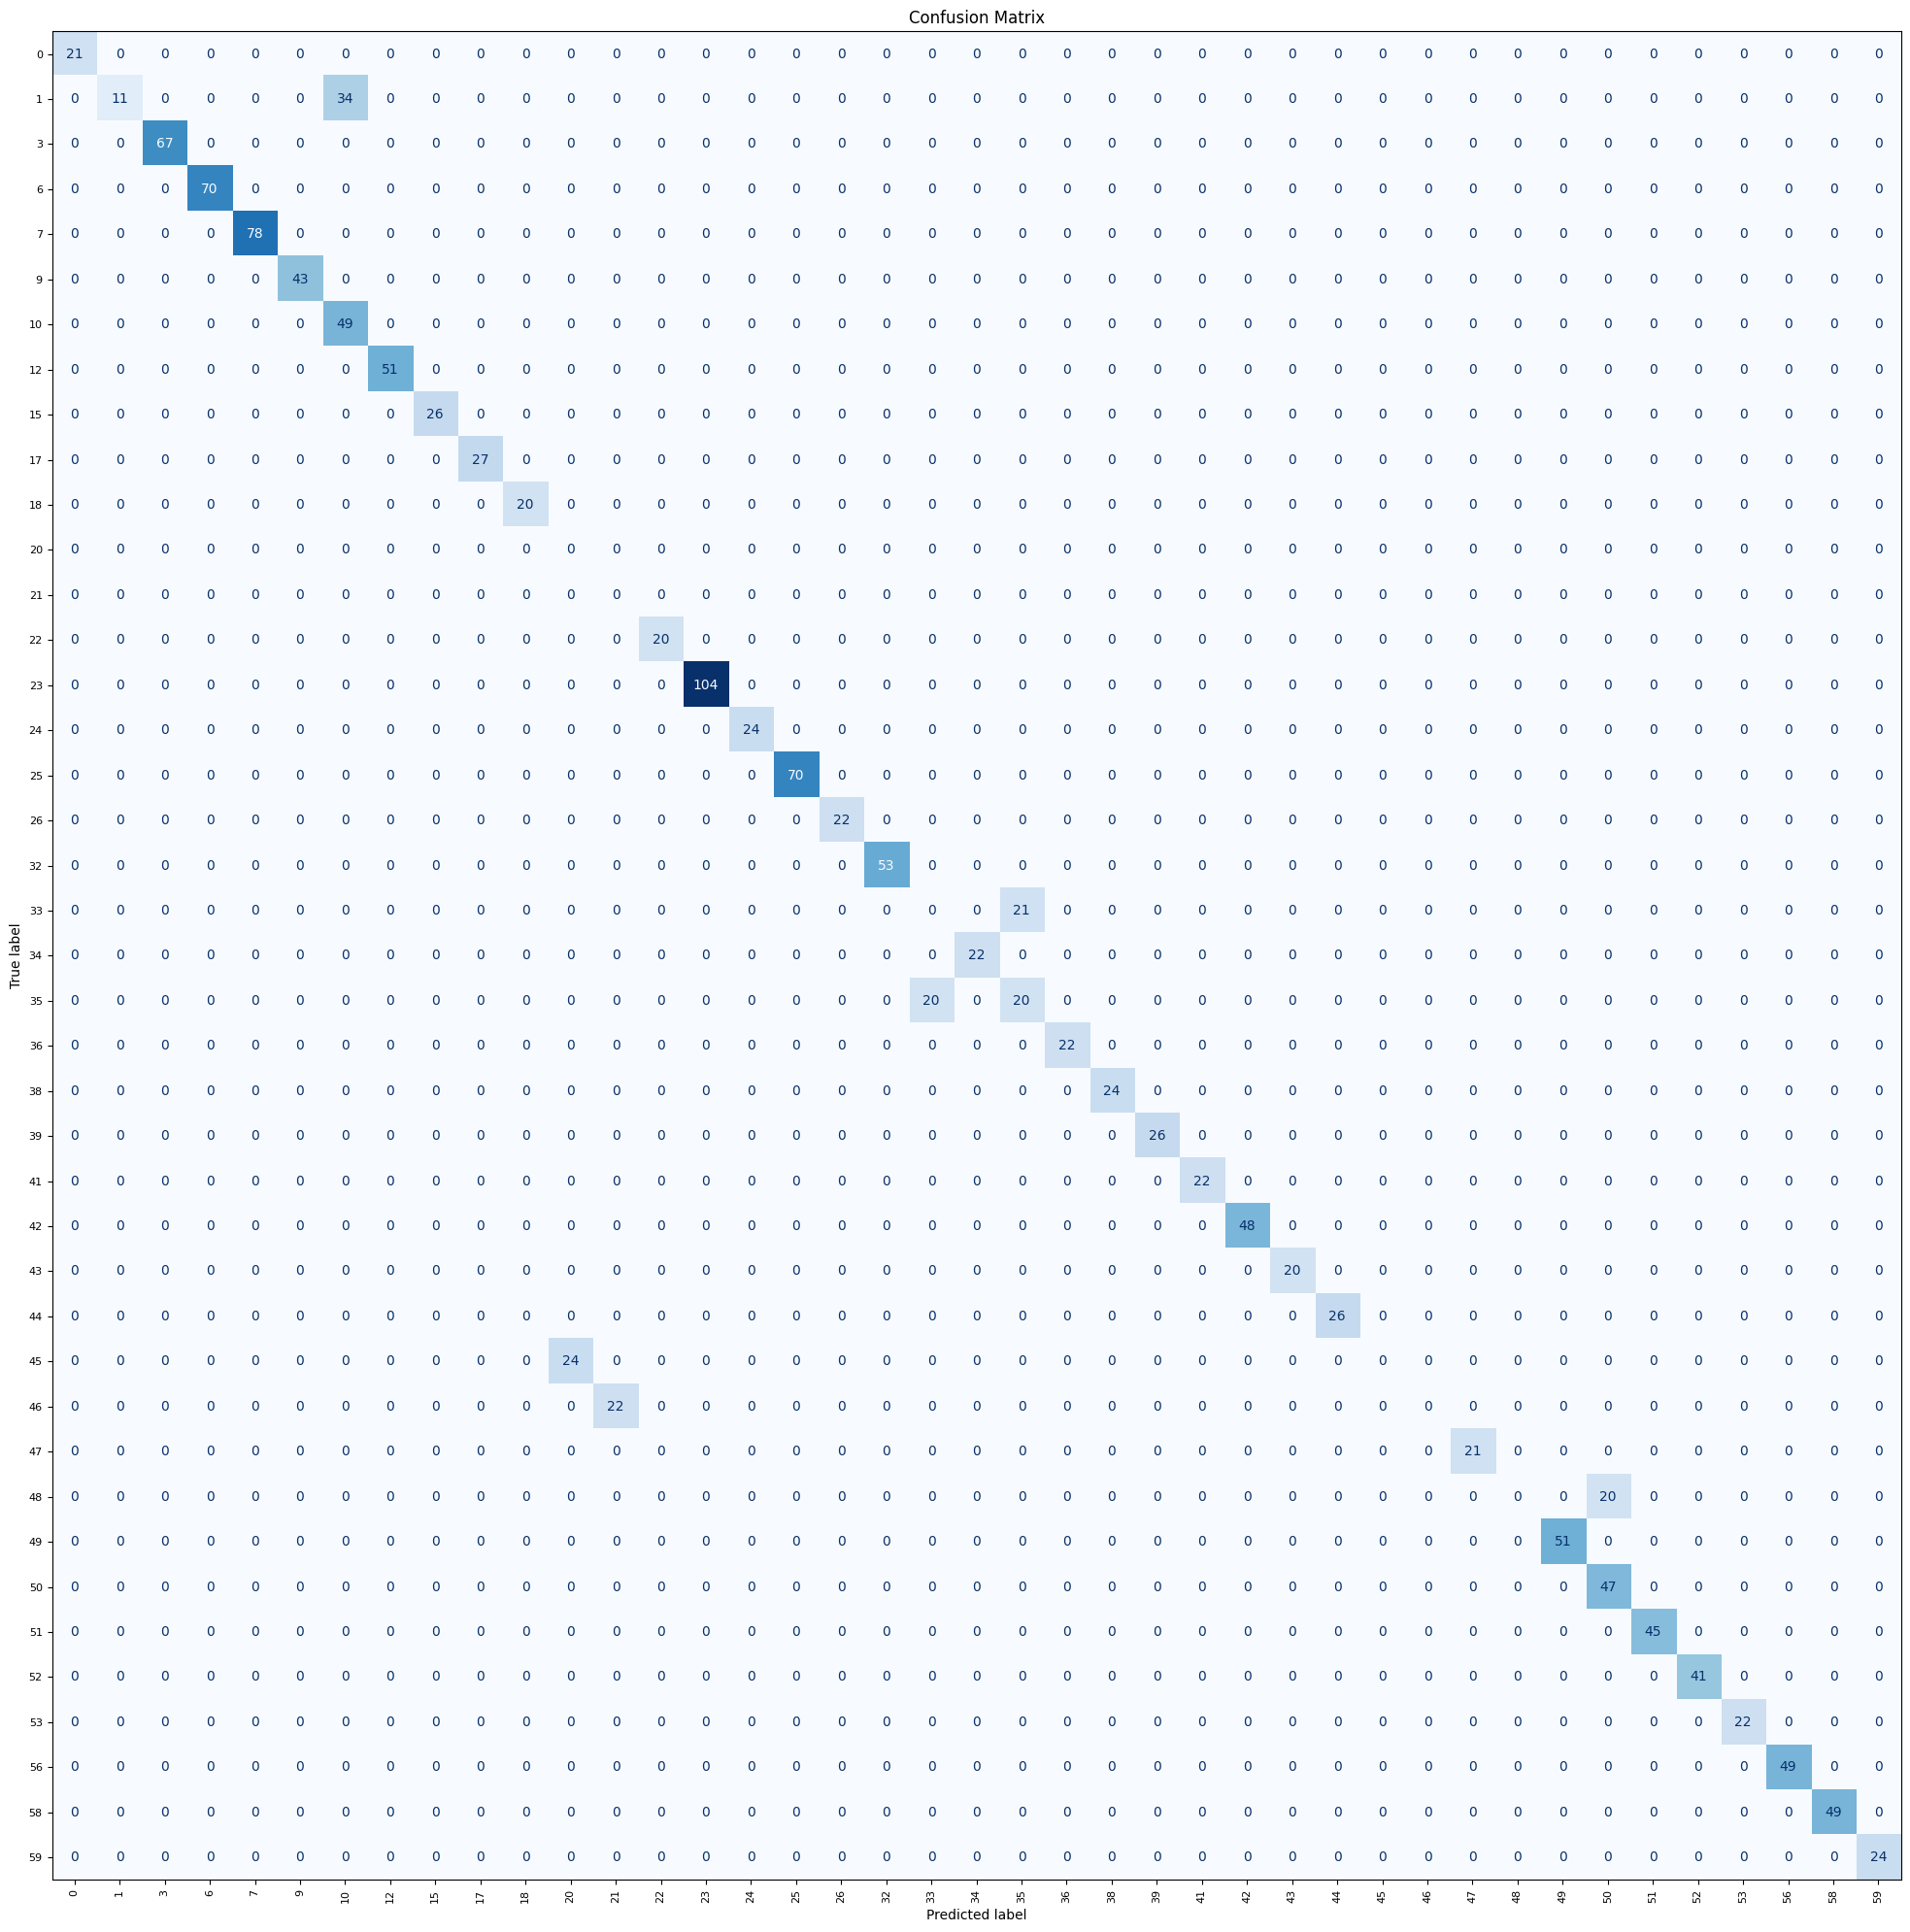

{'accuracy': 0.9044715447154471,
 'predicted_labels': array([ 0,  0,  0, ..., 59, 59, 59]),
 'true_labels': 86       0
 87       0
 88       0
 89       0
 90       0
         ..
 7875    59
 7876    59
 7877    59
 7878    59
 7879    59
 Name: genus_species_label, Length: 1476, dtype: int64}

In [44]:
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE CON SMOTE -----------------------------------")
evaluate_knn_classifier(spectrum_test, genus_species_label_test, knn_genus_species_level_smote)

## Aplicando grid search en busca de los mejores híper parámetros con SMOTE

In [125]:
param_grid_for_SMOTE = {
    'n_neighbors': [3, 5, 7, ],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto','ball_tree', 'brute']
}

In [126]:
grid_search_for_SMOTE = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_for_SMOTE,
    cv=4,  # Validación cruzada
    scoring='accuracy',  # Métrica principal
    verbose=3,  # Mostrar progreso
    n_jobs=-1  # Usar todos los núcleos disponibles
)

grid_search_for_SMOTE.fit(x_train_smote, genus_species_smote)

# Resultados del mejor modelo
print("Best Parameters:", grid_search_for_SMOTE.best_params_)
print("Best Cross-Validated Score:", grid_search_for_SMOTE.best_score_)

Fitting 4 folds for each of 54 candidates, totalling 216 fits
Best Parameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Best Cross-Validated Score: 1.0


In [127]:
joblib.dump(grid_search_for_SMOTE, "grid_search_knn_with_smote.pkl")

['grid_search_knn_with_smote.pkl']

In [45]:
grid_search_knn_with_smote = joblib.load('grid_search_knn_with_smote.pkl')
results = grid_search_knn_with_smote.cv_results_
results_df = pd.DataFrame(results)
results_df

FileNotFoundError: [Errno 2] No such file or directory: 'grid_search_knn_with_smote.pkl'

In [25]:
knn_best_smote = KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='euclidean', algorithm='auto')
knn_best_smote.fit(x_train_smote, genus_species_smote)

KNeighborsClassifier(metric='euclidean', n_neighbors=7)

---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE CON SMOTE -----------------------------------
KNN Classifier Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      0.29      0.45        45
           3       1.00      1.00      1.00        67
           6       1.00      1.00      1.00        70
           7       1.00      1.00      1.00        78
           9       1.00      1.00      1.00        43
          10       0.60      1.00      0.75        49
          12       1.00      1.00      1.00        51
          15       1.00      1.00      1.00        26
          17       1.00      1.00      1.00        27
          18       1.00      1.00      1.00        20
          20       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          22       1.00      1.00      1.00        20
          23       1.

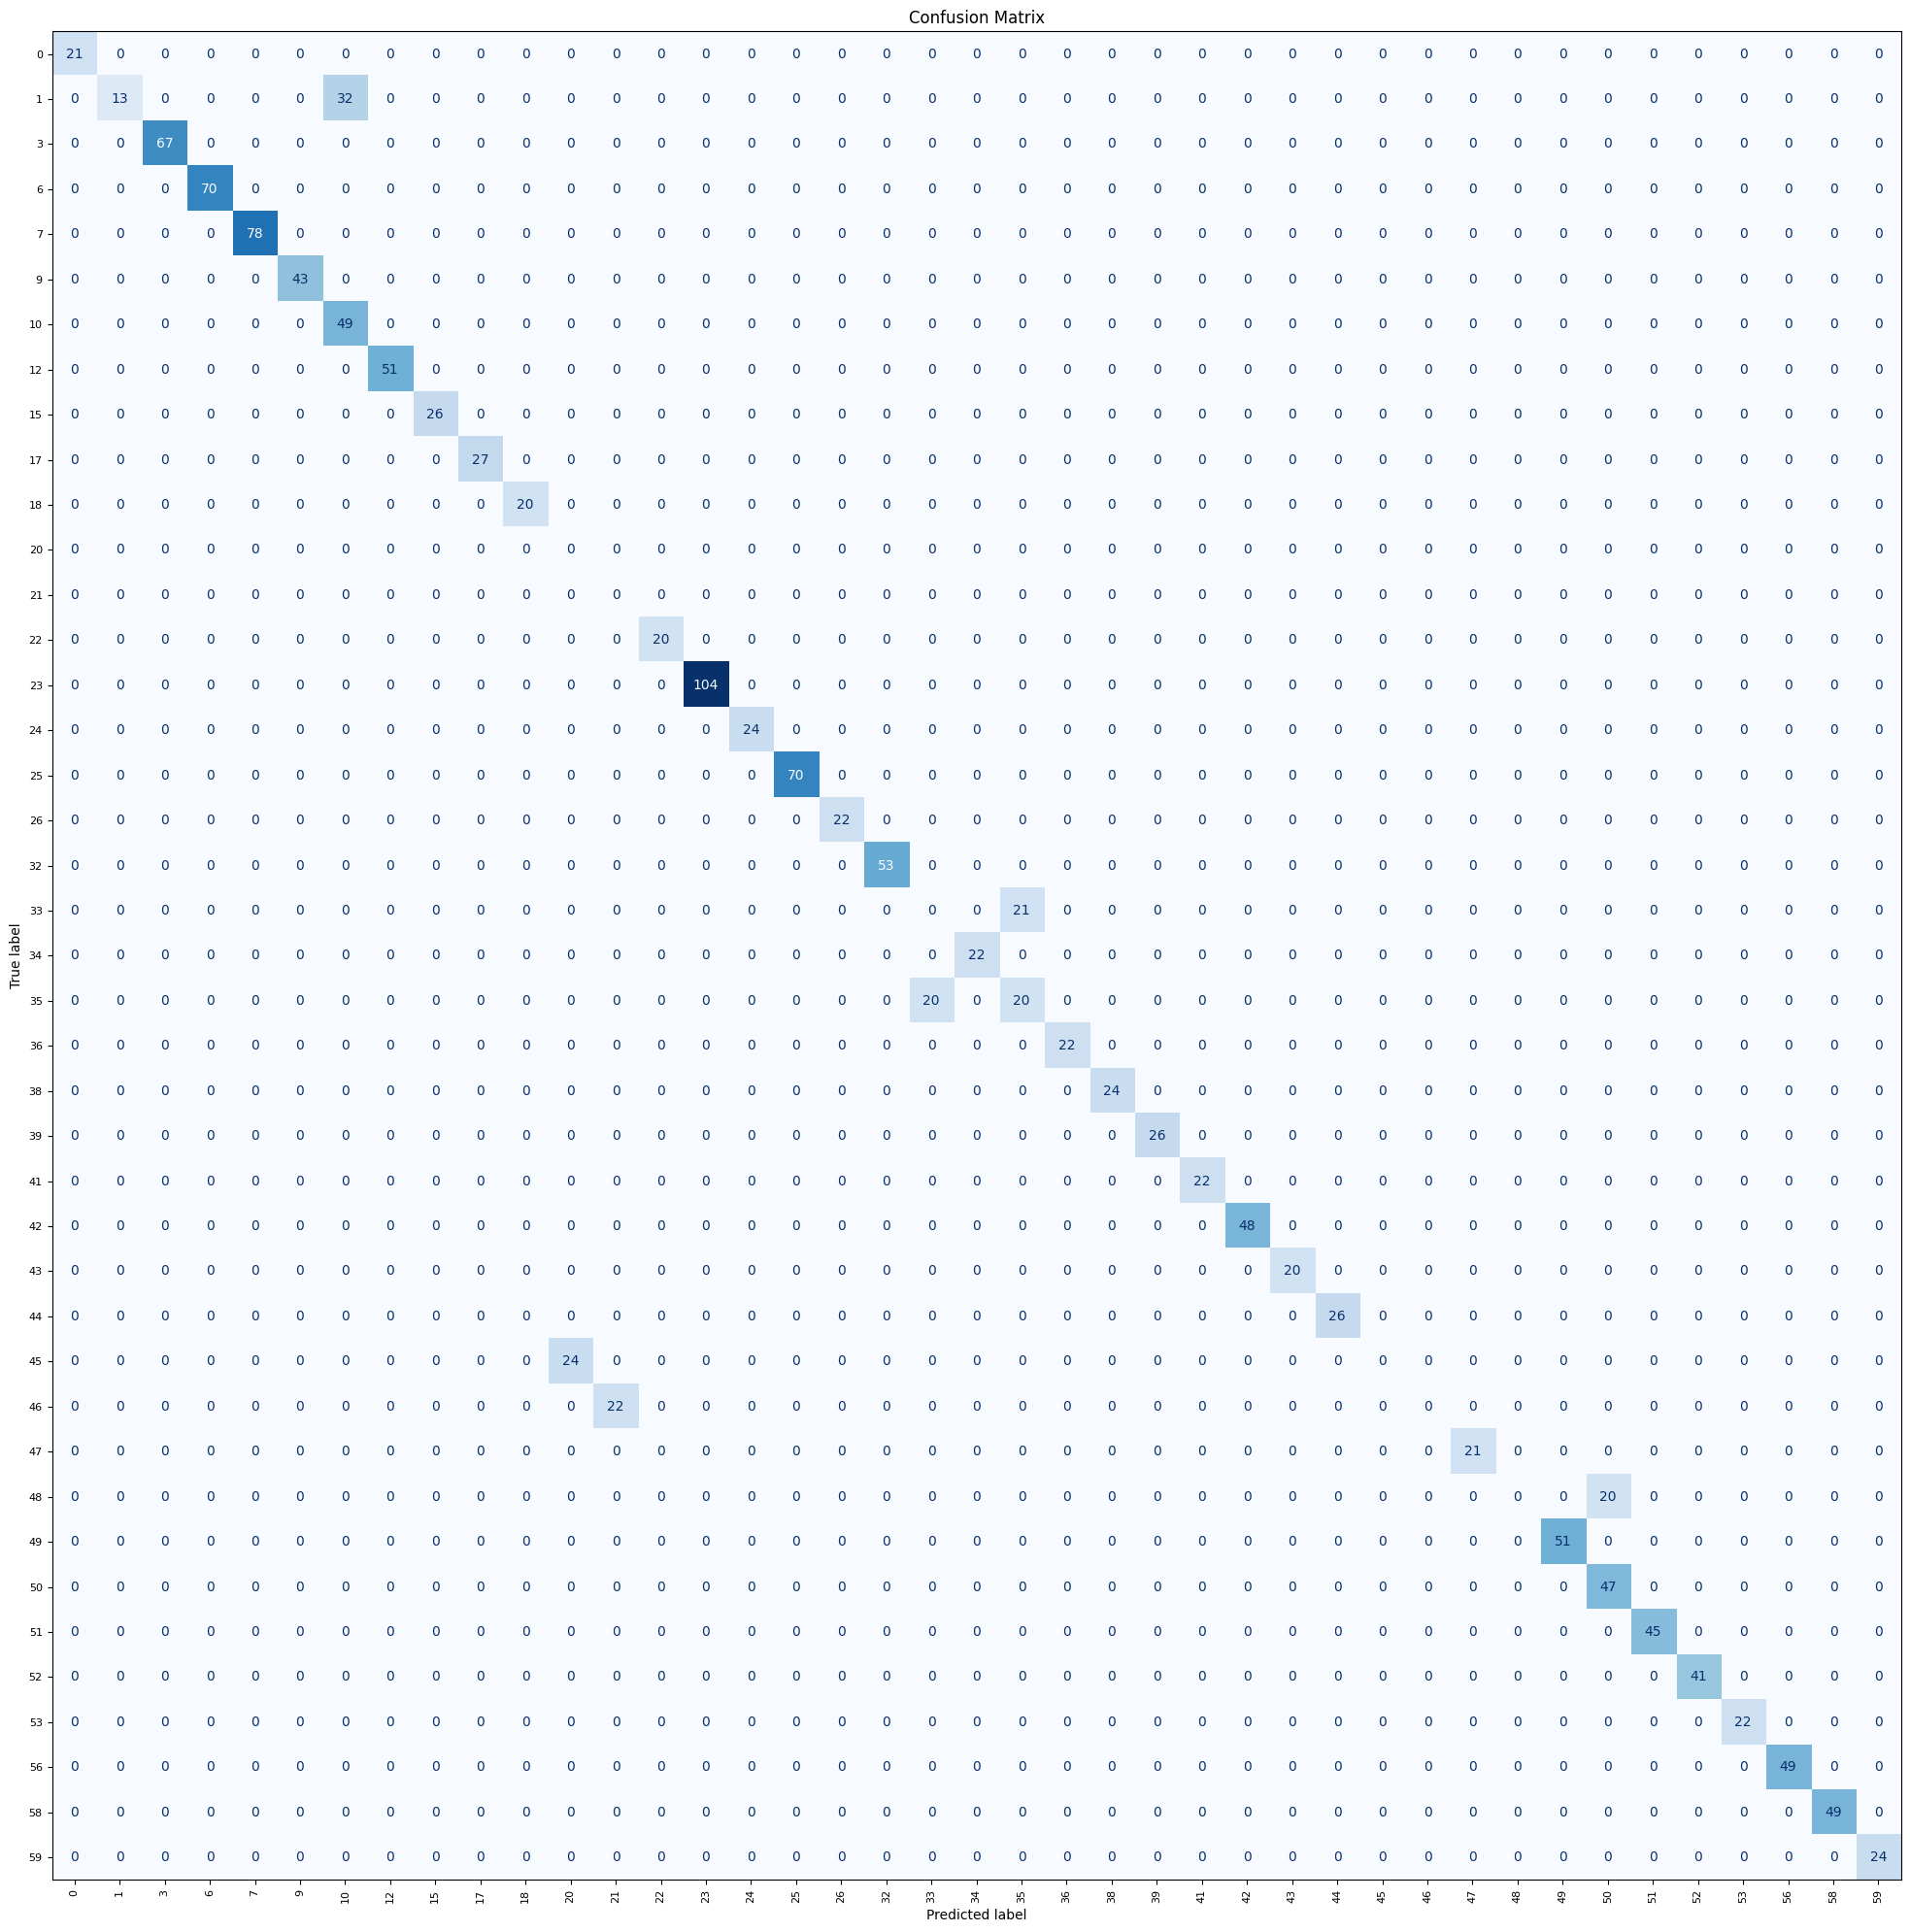

In [26]:
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE CON SMOTE -----------------------------------")
results = evaluate_knn_classifier(spectrum_test, genus_species_label_test, knn_best_smote)

In [28]:
#export knn best_smote
joblib.dump(knn_best_smote, "knn_best_genus_species.pkl")

['knn_best_genus_species.pkl']

In [21]:
knn_best_smote = KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='euclidean', algorithm='auto')
knn_best_smote.fit(x_train_smote, genus_smote)

KNeighborsClassifier(metric='euclidean', n_neighbors=7)

In [2]:
pd.DataFrame(genus_smote).to_csv('genus_test_labels_smote.csv', index=False)

NameError: name 'pd' is not defined

---------------------------- EVALUACIÓN A NIVEL DE GÉNERO CON SMOTE -----------------------------------
KNN Classifier Accuracy: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       497
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00       104
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        70
           5       1.00      1.00      1.00        22
           6       1.00      1.00      1.00       158
           8       1.00      1.00      1.00        50
           9       1.00      1.00      1.00        22
          10       1.00      1.00      1.00        48
          11       1.00      0.50      0.67        92
          12       1.00      1.00      1.00        21
          13       0.00      0.00      0.00        20
          14       0.83      1.00      0.91        98
          15       1.00      1.

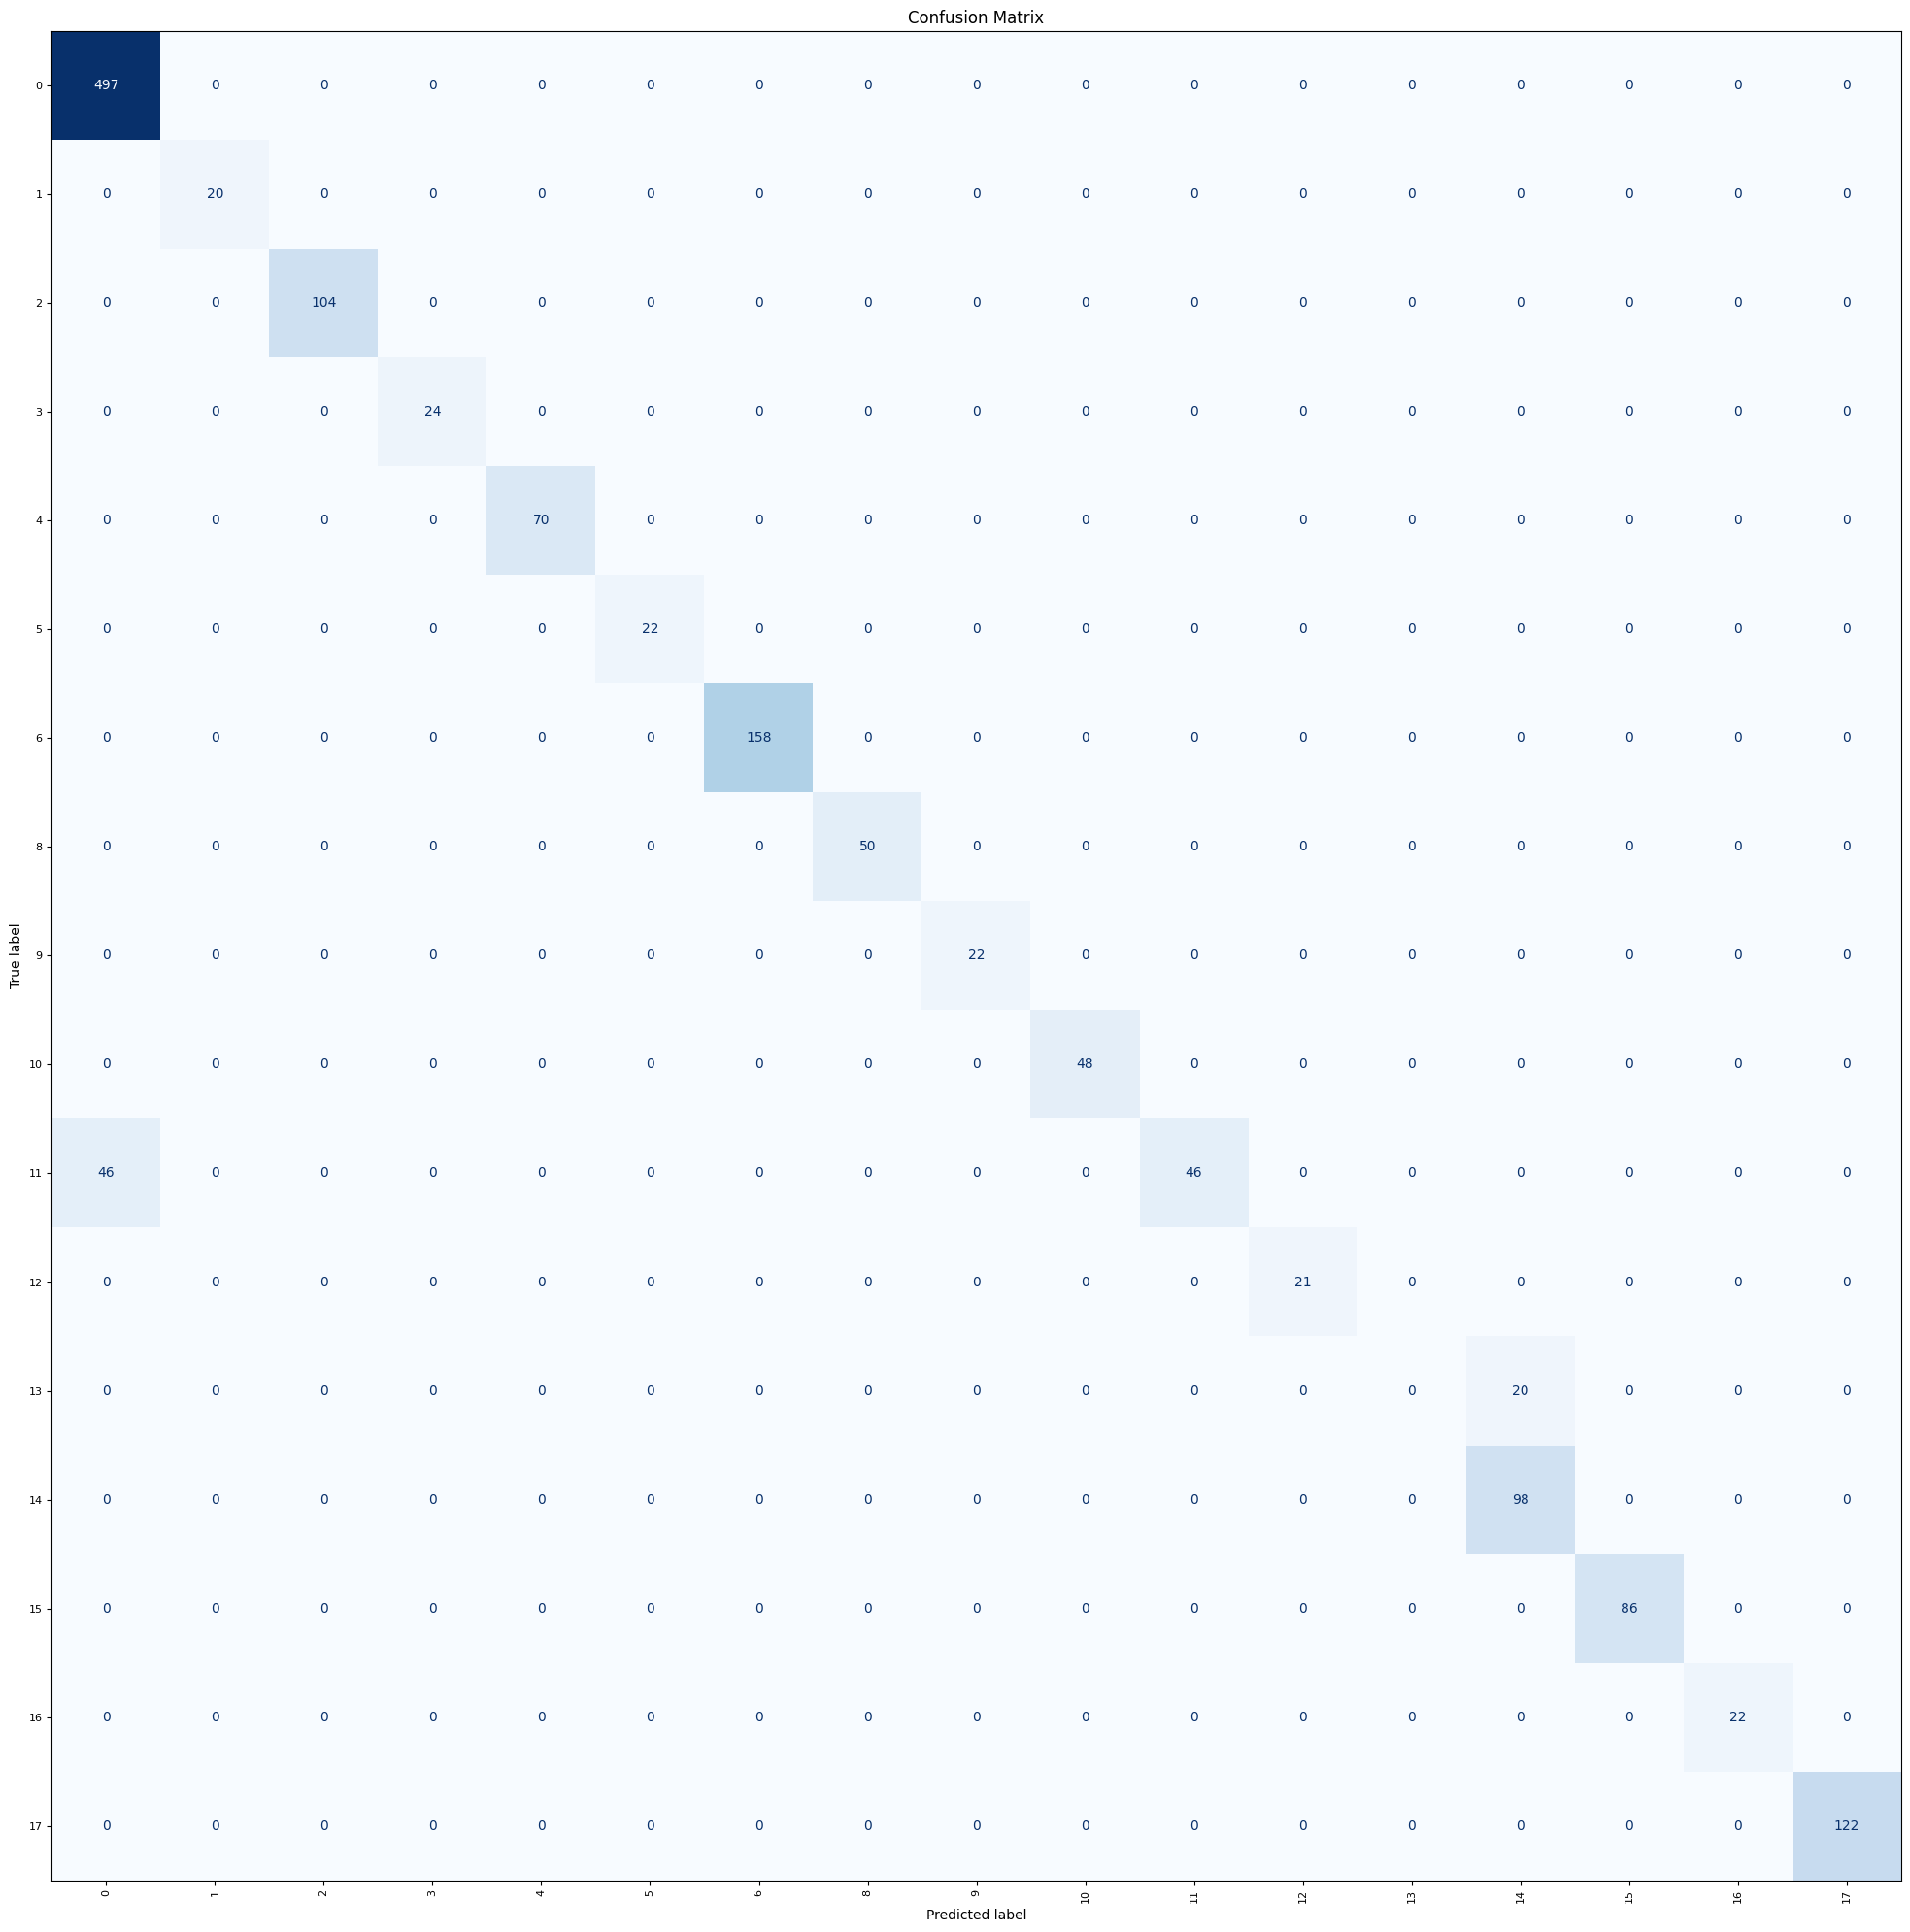

In [22]:
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO CON SMOTE -----------------------------------")
results = evaluate_knn_classifier(spectrum_test, genus_label_test, knn_best_smote)

In [36]:
# Convertir Series a arrays de NumPy
true_labels_column = results['true_labels'].values.reshape(-1, 1)
predicted_labels_column = results['predicted_labels'].reshape(-1, 1)

# Concatenar los datos del test con las etiquetas reales y predichas
combined_data = np.hstack((spectrum_test, true_labels_column, predicted_labels_column))

# Convertir a DataFrame para un análisis más fácil
feature_columns = [f'feature_{i}' for i in range(spectrum_test.shape[1])]
df = pd.DataFrame(combined_data, columns=feature_columns + ['real_label', 'predicted_label'])

In [37]:

class_eleven_bad_classified = df[(df['real_label'] == 11) & (df['predicted_label'] == 0)]
class_eleven_well_classified = df[(df['real_label'] == 11) & (df['predicted_label'] == 11)]
class_zero_well_classified = df[(df['real_label'] == 0) & (df['predicted_label'] == 0)]


In [25]:
feature_columns = [f'feature_{i}' for i in range(3000)]
wrong_spectra_data_11 = class_eleven_bad_classified[feature_columns]
correct_spectra_data_11 = class_eleven_well_classified[feature_columns]
correct_spectra_data_0 = class_zero_well_classified[feature_columns]

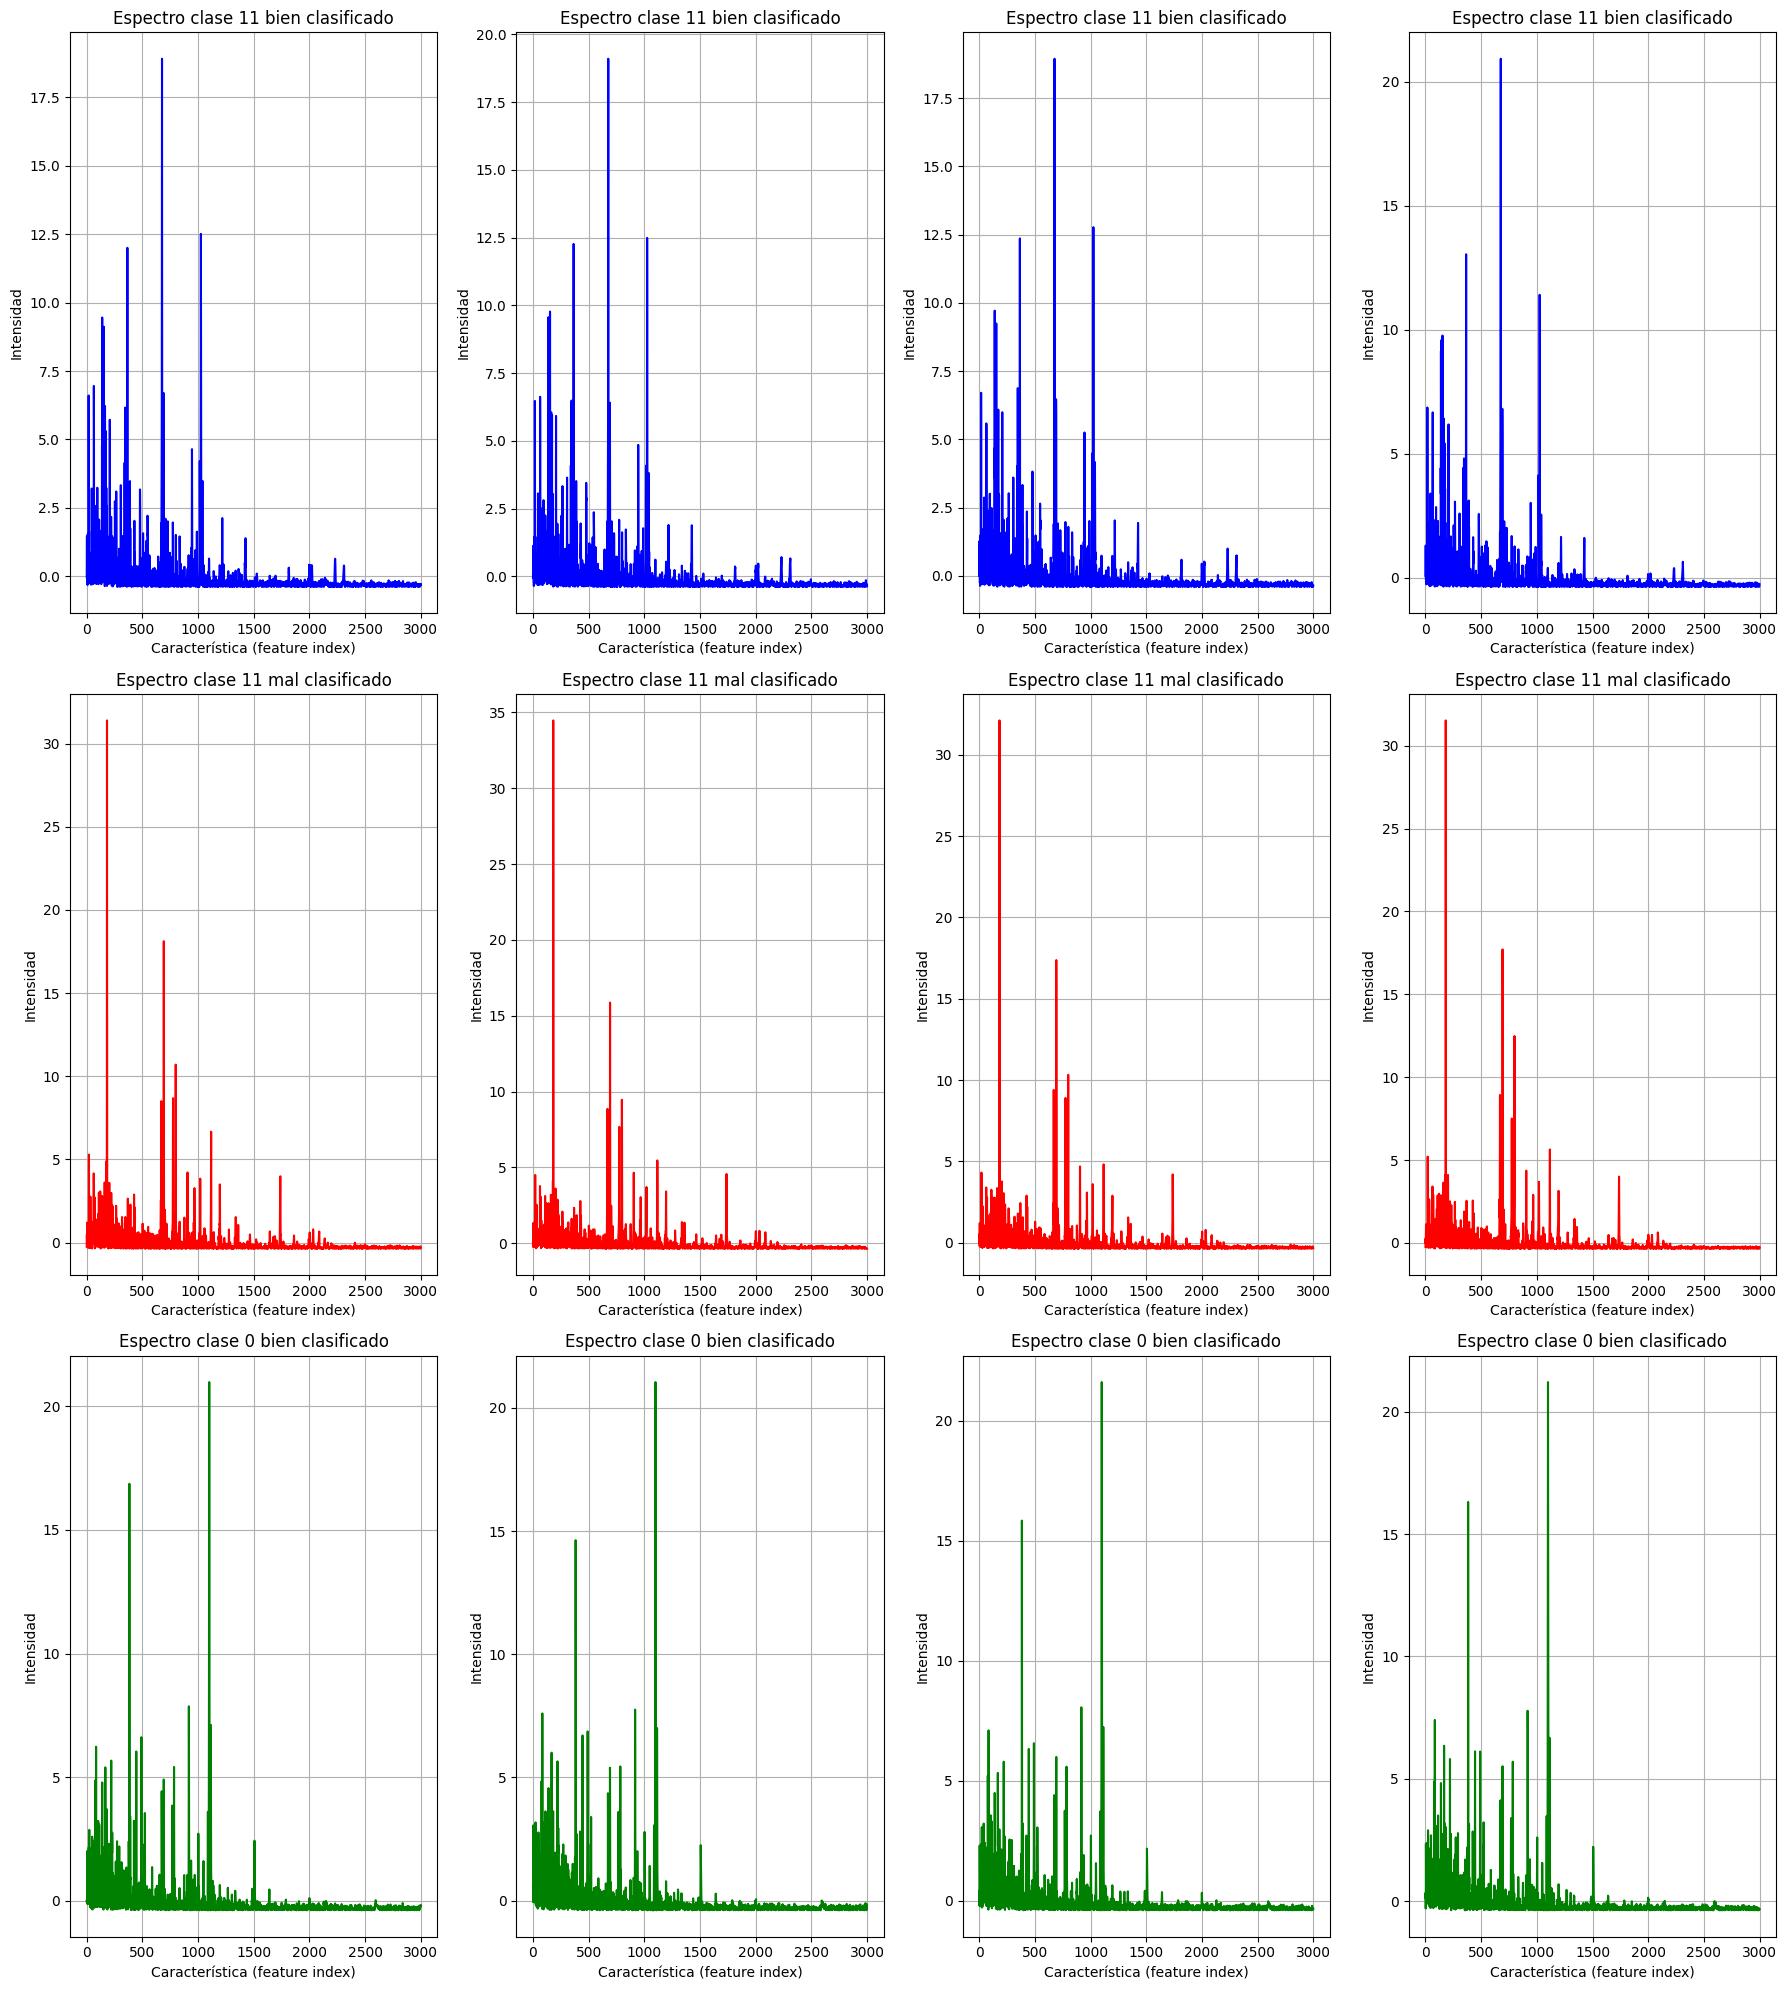

In [26]:


# Crear la figura y los ejes para 3 filas y 3 columnas
fig, axes = plt.subplots(3, 4, figsize=(18, 20))  # 5 filas y 3 columnas

# Iterar para graficar cada espectro en su respectiva columna
for i in range(4):
    # Espectro clase 11 bien clasificado (Columna 0)
    axes[0, i].plot(range(3000), correct_spectra_data_11.iloc[i], color='blue')
    axes[0, i].set_title(f'Espectro clase 11 bien clasificado', fontsize=12)
    axes[0, i].set_xlabel('Característica (feature index)', fontsize=10)
    axes[0, i].set_ylabel('Intensidad', fontsize=10)
    axes[0, i].grid(True)

    # Espectro clase 11 mal clasificado (Columna 1)
    axes[1,i].plot(range(3000), wrong_spectra_data_11.iloc[i], color='red')
    axes[1,i].set_title(f'Espectro clase 11 mal clasificado', fontsize=12)
    axes[1,i].set_xlabel('Característica (feature index)', fontsize=10)
    axes[1,i].set_ylabel('Intensidad', fontsize=10)
    axes[1,i].grid(True)

    # Espectro clase 0 bien clasificado (Columna 2)
    axes[2,i].plot(range(3000), correct_spectra_data_0.iloc[i], color='green')
    axes[2,i].set_title(f'Espectro clase 0 bien clasificado', fontsize=12)
    axes[2,i].set_xlabel('Característica (feature index)', fontsize=10)
    axes[2,i].set_ylabel('Intensidad', fontsize=10)
    axes[2,i].grid(True)

# Ajustar el espacio entre gráficos
plt.tight_layout()
plt.show()



In [27]:
class_thirteen_bad_classified = df[(df['real_label'] == 13) & (df['predicted_label'] != 13)]
class_fourteen_well_classified = df[(df['real_label'] == 14) & (df['predicted_label'] == 14)]

In [28]:
wrong_spectra_data_11 = class_thirteen_bad_classified[feature_columns]
correct_spectra_data_14 = class_fourteen_well_classified[feature_columns]

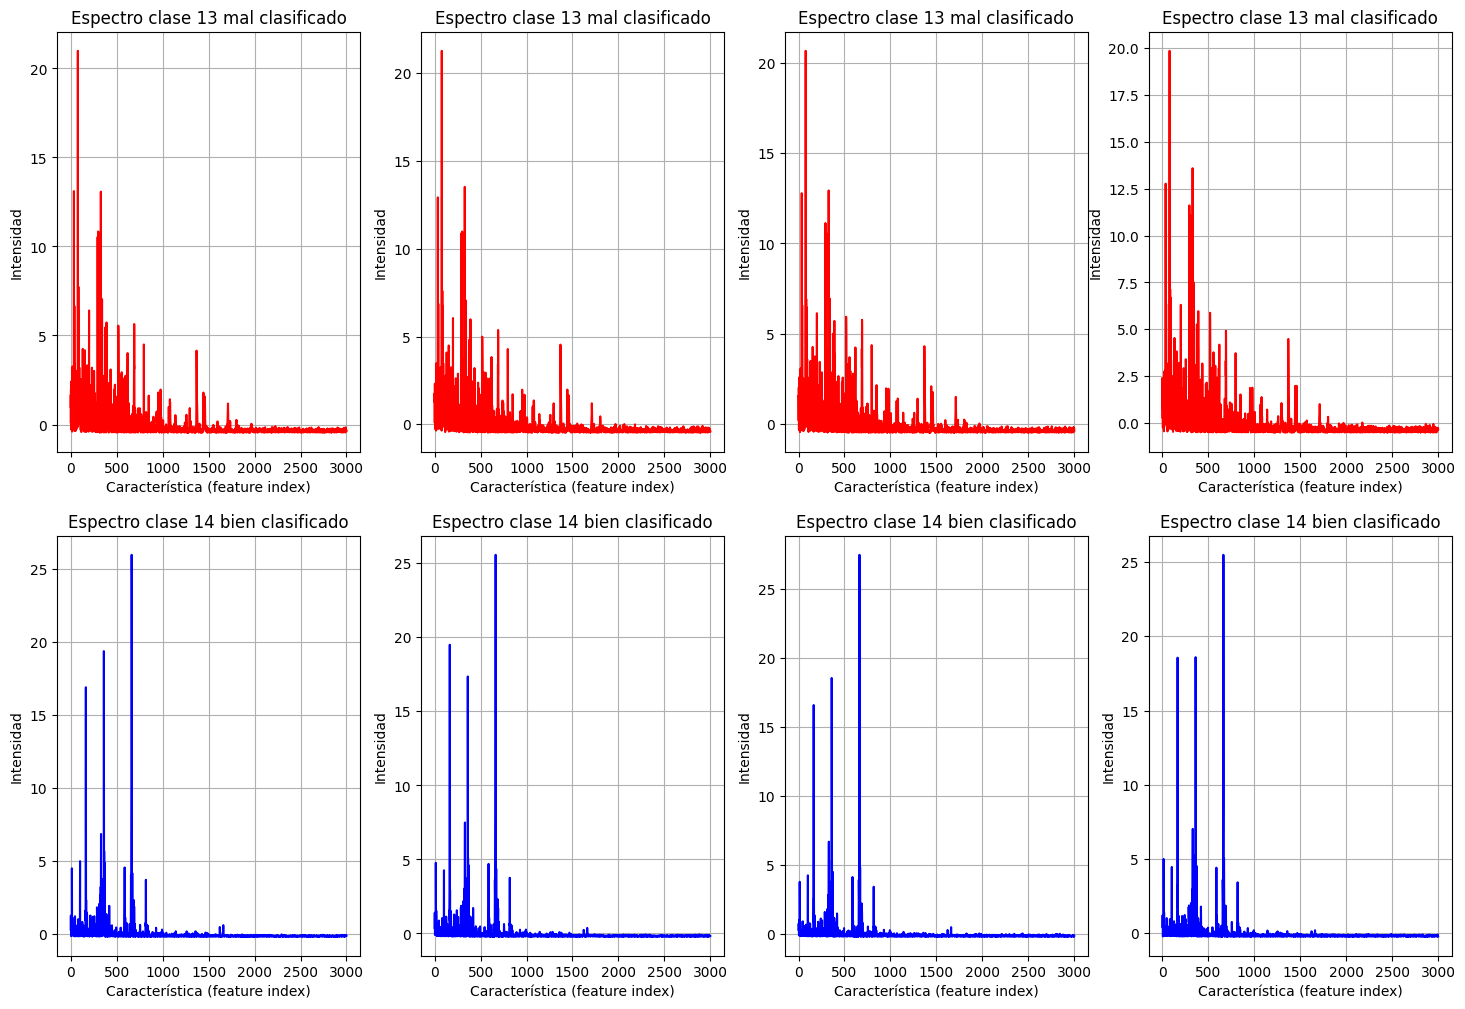

In [29]:
fig, axes = plt.subplots(2, 4, figsize=(18, 12))

for i in range(4):
    axes[0, i].plot(range(3000), wrong_spectra_data_11.iloc[i], color='red')
    axes[0, i].set_title(f'Espectro clase 13 mal clasificado', fontsize=12)
    axes[0,i].set_xlabel('Característica (feature index)', fontsize=10)
    axes[0,i].set_ylabel('Intensidad', fontsize=10)
    axes[0,i].grid(True)
    axes[1, i].plot(range(3000), correct_spectra_data_14.iloc[i], color='blue')
    axes[1, i].set_title(f'Espectro clase 14 bien clasificado', fontsize=12)
    axes[1,i].set_xlabel('Característica (feature index)', fontsize=10)
    axes[1,i].set_ylabel('Intensidad', fontsize=10)
    axes[1,i].grid(True)

In [46]:
#Agrupa genus_smote y cuenta cuantas veces aparece cada uno
genus_smote_count = Counter(genus_smote)
#Imprime el número de veces que aparece cada genus en formato bonito
print(genus_smote_count)


Counter({np.int64(0): 8228, np.int64(6): 3740, np.int64(17): 2244, np.int64(11): 1496, np.int64(8): 748, np.int64(9): 748, np.int64(14): 748, np.int64(15): 748, np.int64(1): 374, np.int64(2): 374, np.int64(3): 374, np.int64(4): 374, np.int64(5): 374, np.int64(7): 374, np.int64(10): 374, np.int64(12): 374, np.int64(13): 374, np.int64(16): 374})


In [31]:
! pip install umap-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\aleta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Users\aleta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\aleta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


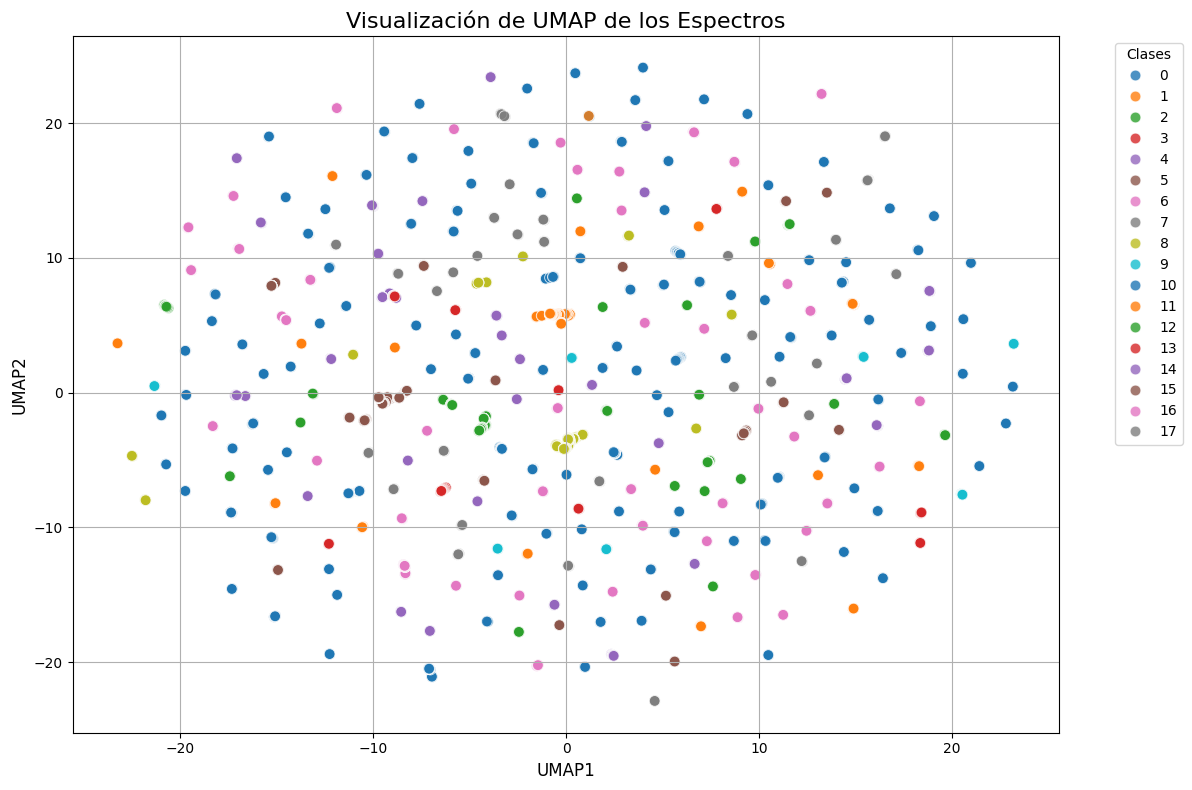

In [42]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Supongamos que 'spectrum_test' es tu conjunto de datos preprocesado
# Y 'y_test' son las etiquetas reales de las muestras

# Aplicar UMAP para reducir a 2 dimensiones
umap_reducer = umap.UMAP(n_neighbors=18, min_dist=0.1, random_state=42)
embedding_umap = umap_reducer.fit_transform(spectrum_completo)

# Convertir a DataFrame para facilitar la visualización
umap_df = pd.DataFrame(embedding_umap, columns=['UMAP1', 'UMAP2'])
umap_df['label'] = genus_label_completo

# Graficar
plt.figure(figsize=(12, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='label', palette='tab10', data=umap_df, s=60, alpha=0.8)

plt.title('Visualización de UMAP de los Espectros', fontsize=16)
plt.xlabel('UMAP1', fontsize=12)
plt.ylabel('UMAP2', fontsize=12)
plt.legend(title='Clases', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\aleta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


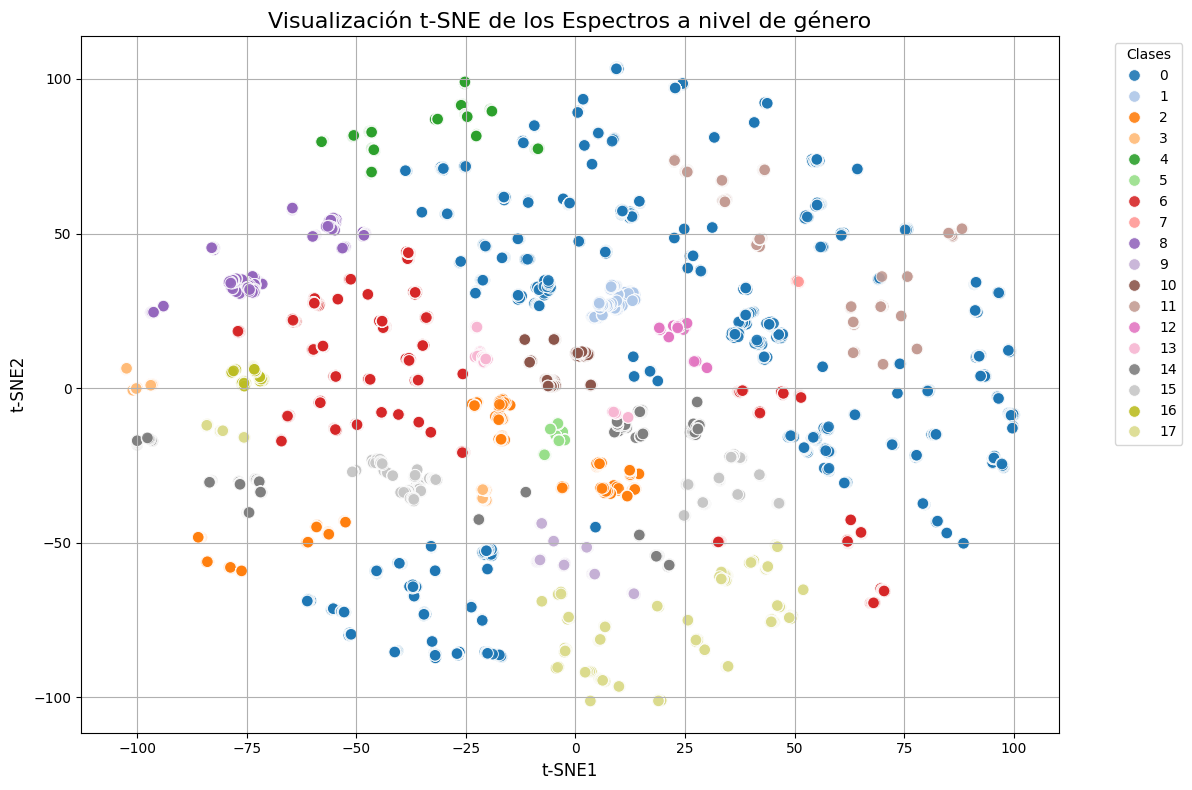

In [45]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Aplicar t-SNE para reducir a 2 dimensiones
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
embedding_tsne = tsne.fit_transform(spectrum_completo)

# Convertir a DataFrame para facilitar la visualización
tsne_df = pd.DataFrame(embedding_tsne, columns=['t-SNE1', 't-SNE2'])
tsne_df['label'] = genus_label_completo

# Graficar con una paleta de colores más diferenciada
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='t-SNE1', 
    y='t-SNE2', 
    hue='label', 
    palette='tab20',  # Cambiar la paleta de colores aquí
    data=tsne_df, 
    s=70, 
    alpha=0.9
)

# Personalización del gráfico
plt.title('Visualización t-SNE de los Espectros a nivel de género', fontsize=16)
plt.xlabel('t-SNE1', fontsize=12)
plt.ylabel('t-SNE2', fontsize=12)
plt.legend(title='Clases', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


# Random Forest

## Random forest con parámetros aleatorios

In [35]:
type(x_train_smote[0][0])

numpy.float64

In [29]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(x_train_smote, genus_species_smote)

RandomForestClassifier(random_state=42)

---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE CON RANDOM FOREST -----------------------------------
KNN Classifier Accuracy: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       0.68      0.51      0.58        45
           3       1.00      1.00      1.00        67
           6       1.00      1.00      1.00        70
           7       0.99      1.00      0.99        78
           9       0.80      1.00      0.89        43
          10       0.67      0.90      0.77        49
          12       0.61      1.00      0.76        51
          15       1.00      1.00      1.00        26
          17       1.00      0.04      0.07        27
          18       1.00      0.90      0.95        20
          21       0.00      0.00      0.00         0
          22       1.00      1.00      1.00        20
          23       1.00      1.00      1.00       104
          24 

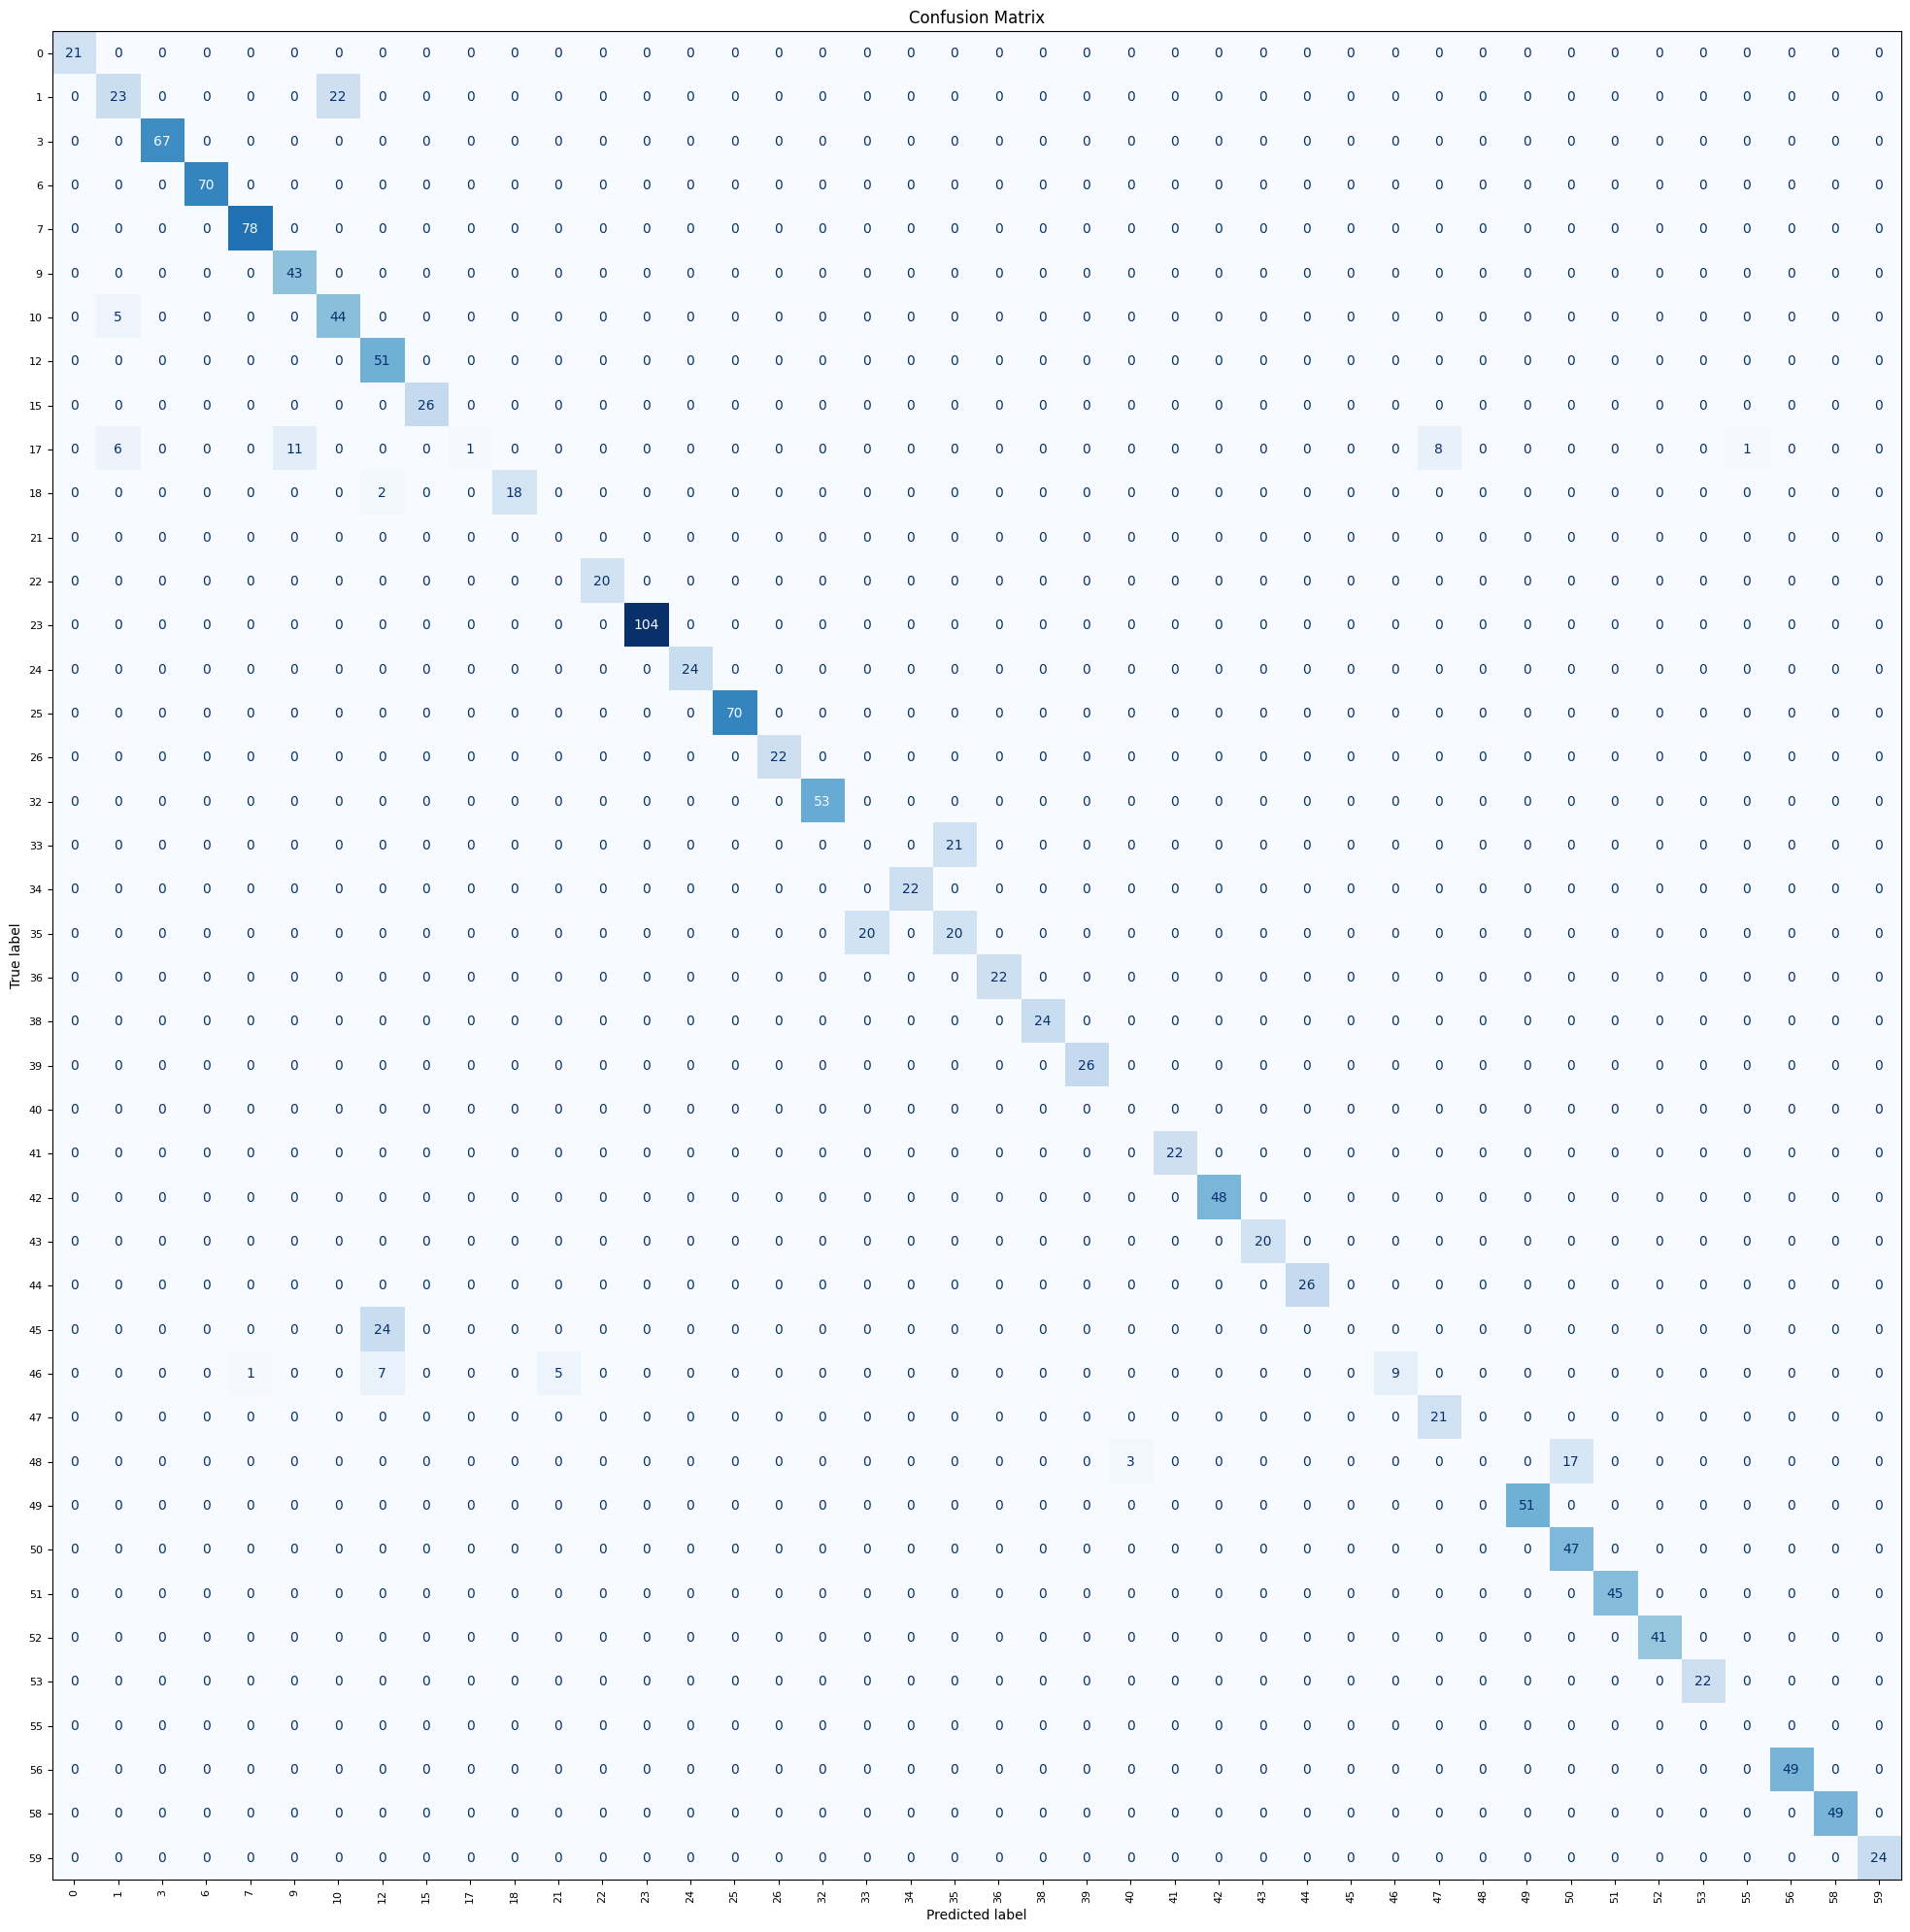

{'accuracy': 0.8963414634146342,
 'predicted_labels': array([ 0,  0,  0, ..., 59, 59, 59]),
 'true_labels': 86       0
 87       0
 88       0
 89       0
 90       0
         ..
 7875    59
 7876    59
 7877    59
 7878    59
 7879    59
 Name: genus_species_label, Length: 1476, dtype: int64}

In [30]:
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE CON RANDOM FOREST -----------------------------------")
evaluate_knn_classifier(spectrum_test, genus_species_label_test, random_forest)

In [39]:
#export model
joblib.dump(random_forest, "random_forest_model.pkl")

['random_forest_model.pkl']

In [37]:
import shap
import numpy as np

# Convertir los datos a numpy arrays con el mismo tipo que el entrenamiento (float64)
X_train = x_train_smote
X_test = spectrum_test

# Filtrar muestras con etiqueta 6
mask_label_6 = genus_species_label_test.values.flatten() == 6
X_test_label_6 = X_test[mask_label_6].astype(np.float64)  # Convertimos a float64

if X_test_label_6.shape[0] > 0:
    # Usamos PermutationExplainer en lugar de TreeExplainer
    explainer = shap.Explainer(random_forest.predict, X_train[:100], algorithm="permutation")

    # Explicar solo 3 muestras con la etiqueta 6
    shap_values_label_6 = explainer(X_test_label_6[:3], max_evals=6001)

    # Mostrar gráfico de valores SHAP
    shap.summary_plot(shap_values_label_6, X_test_label_6[:3], feature_names=[f"f{i}" for i in range(X_train.shape[1])])
else:
    print("No hay muestras con la etiqueta 6 disponibles.")

MemoryError: Unable to allocate 13.4 GiB for an array with shape (600100, 3000) and data type float64

## Buscando mejores hiperparámetros para Random Forest con Grid Search

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Definir el conjunto de hiperparámetros
param_grid = {
    'n_estimators': [10, 20, 50, 100],  # Número de árboles
    'max_depth': [None, 10, 20, 30],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras en una hoja
    'max_features': ['sqrt', 'log2'],  # Número de características consideradas en cada árbol
    'bootstrap': [True, False]  # Si se usa muestreo con reemplazo
}

# Inicializar el modelo
random_forest = RandomForestClassifier(random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=random_forest,
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 folds
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=2,  # Mostrar progreso
    scoring='accuracy'  # Usar precisión como métrica
)

# Ejecutar la búsqueda en los datos de entrenamiento
grid_search.fit(x_train_smote, genus_species_smote)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("Mejor precisión obtenida:", grid_search.best_score_)


Fitting 5 folds for each of 576 candidates, totalling 2880 fits


KeyboardInterrupt: 